In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import networkx as nx
from scipy.stats import f_oneway, f

sns.set_theme()

In [4]:
from src.utils.story.processing import (
    remove_low_alcohol,
    shift_past_count,
    create_time_variables,
)

from src.utils.story.selection import (
    compute_cumulative_ratings_count,
    remove_before_month,
)

from src.utils.story.beer_knowledge import (
    number_of_beer_per_style,
    add_all_knowledge,
    add_experts,
    get_beer_required_expert,
    get_expert_count,
    add_novices,
    get_novice_count,
    get_expert_vs_novice
)

from src.utils.story.nlp import tukey_test, create_digraph
from src.utils.story.preferences import analyze_relationships, create_preference_digraph

# 1. Pre-processing

In [5]:
df_ba_beers = pd.read_csv("src/data/beer_advocate/beers.csv")
# df_ba_breweries = pd.read_csv('src/data/beer_advocate/breweries.csv')
df_ba_users = pd.read_csv("src/data/beer_advocate/users.csv")
df_ba_ratings = pd.read_csv("src/data/beer_advocate/ratings.csv")
df_ba_user_beer_style_past_ratings = pd.read_csv(
    "src/data/beer_advocate/user_beer_style_past_ratings.csv"
)

In [6]:
df_rb_beers = pd.read_csv("src/data/rate_beer/beers.csv")
# df_rb_breweries = pd.read_csv('src/data/rate_beer/breweries.csv')
df_rb_users = pd.read_csv("src/data/rate_beer/users.csv")
df_rb_ratings = pd.read_csv("src/data/rate_beer/ratings.csv")
df_rb_user_beer_style_past_ratings = pd.read_csv(
    "src/data/rate_beer/user_beer_style_past_ratings.csv"
)

In [7]:
df_ba_ratings, df_ba_user_beer_style_past_ratings = remove_low_alcohol(
    df_ba_ratings, df_ba_user_beer_style_past_ratings
)
df_rb_ratings, df_rb_user_beer_style_past_ratings = remove_low_alcohol(
    df_rb_ratings, df_rb_user_beer_style_past_ratings
)

df_ba_ratings = shift_past_count(df_ba_ratings)
df_rb_ratings = shift_past_count(df_rb_ratings)

df_ba_ratings = create_time_variables(df_ba_ratings)
df_rb_ratings = create_time_variables(df_rb_ratings)

df_ba_user_beer_style_past_ratings = create_time_variables(
    df_ba_user_beer_style_past_ratings
)
df_rb_user_beer_style_past_ratings = create_time_variables(
    df_rb_user_beer_style_past_ratings
)

# 2. Data selection

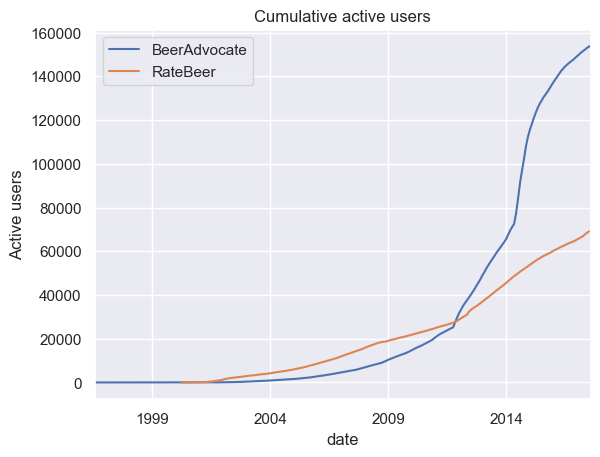

In [8]:
plt.title("Cumulative active users")
plt.xlabel("Month")
plt.ylabel("Active users")
pd.to_datetime(
    df_ba_ratings.sort_values(["date"]).groupby("user_id")["date"].first(), unit="s"
).dt.to_period("M").value_counts().sort_index().cumsum().plot(label="BeerAdvocate")
pd.to_datetime(
    df_rb_ratings.sort_values(["date"]).groupby("user_id")["date"].first(), unit="s"
).dt.to_period("M").value_counts().sort_index().cumsum().plot(label="RateBeer")
plt.legend()

**Interpretation :** Here is the plot of cumulative users for our two websites. The number of users for both of our websites start growing significantly after the 2004 year. We see two trends in this graph. From the 2000's to the 2012 period, we see that RateBeer is more popular than BeerAdvocate, cumulating more users. After 2012 we see the trend inverting herself, now BeerAdvocate is getting way more popular than RateBeer and is growing his userbase way faster. Currently we see that BeerAdvocate has more than twice the cumulative users of RateBeer. 

<Axes: title={'center': 'Cumulative ratings count'}, xlabel='month', ylabel='Cumulative ratings count'>

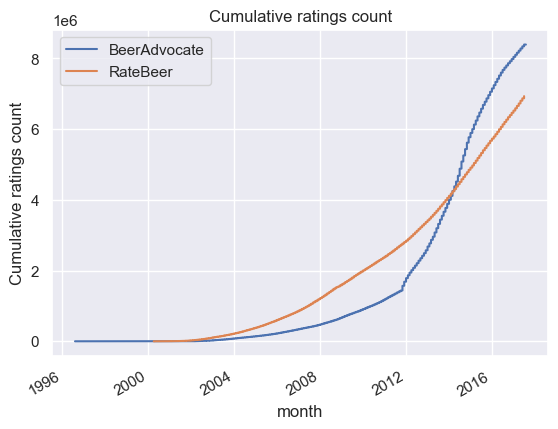

In [9]:
fig, ax = plt.subplots()
plt.title("Cumulative ratings count")
plt.xlabel("Month")
plt.ylabel("Cumulative ratings count")
compute_cumulative_ratings_count(df_ba_ratings).plot(
    x="month", y="cumulative_ratings_count", label="BeerAdvocate", ax=ax
)
compute_cumulative_ratings_count(df_rb_ratings).plot(
    x="month", y="cumulative_ratings_count", label="RateBeer", ax=ax
)

**Interpretation :** Here is the plot of cumulative ratings for our two websites. The number of ratings for both of our websites start growing significantly after the 2004 year. We see two trends in this graph. From the 2000's to the 2012 period, we see that RateBeer is more popular than BeerAdvocate, cumulating more ratings. After 2012 we see the trend inverting herself, now BeerAdvocate is getting way more popular than RateBeer and is growing his cumulative rating count way faster. Currently we see that BeerAdvocate has approximately 20% more ratings than Rate Beer.

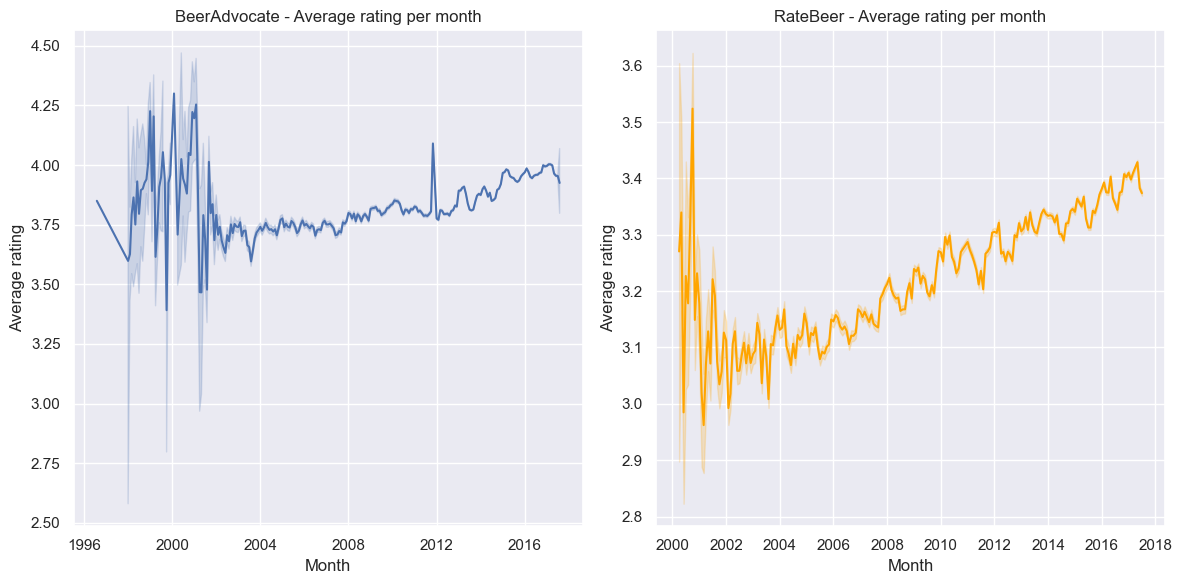

In [10]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title('BeerAdvocate - Average rating per month')
axs[0].set_xlabel('Month')
axs[0].set_ylabel('Average rating')
sns.lineplot(data=df_ba_ratings, x='month', y='rating', ax=axs[0])

axs[1].set_title('RateBeer - Average rating per month')
axs[1].set_xlabel('Month')
axs[1].set_ylabel('Average rating')
sns.lineplot(data=df_rb_ratings, x='month', y='rating', ax=axs[1], color='orange')

plt.tight_layout()
plt.show()

*Interpretation* : These graphs show the average beer ratings dependent on time for our two websites. For the two platforms we see that the mean of ratings pre 2004 is very noisy. A lot of fluctuations and a very high standard deviation. After this 2004 date, the average ratings are getting smoother and less volatile. This comes from the fact that before 2004 few people were active users of the websites, creating a lot of noise. As we saw in precedent graphics, after 2004 the cumulative number of ratings and users started to grow significantly for both websites thus lowering the noise in the average ratings. For this reason in our analysis we chose to retain only ratings that are after 2004.

In [11]:
df_ba_current_beer_per_style = number_of_beer_per_style(df_ba_ratings)
df_rb_current_beer_per_style = number_of_beer_per_style(df_rb_ratings)

df_ba_ratings, df_ba_user_beer_style_past_ratings = remove_before_month(
    df_ba_ratings, df_ba_user_beer_style_past_ratings, "2004-01"
)
df_rb_ratings, df_rb_user_beer_style_past_ratings = remove_before_month(
    df_rb_ratings, df_rb_user_beer_style_past_ratings, "2004-01"
)

# 3. Beer Advocate vs Rate Beer

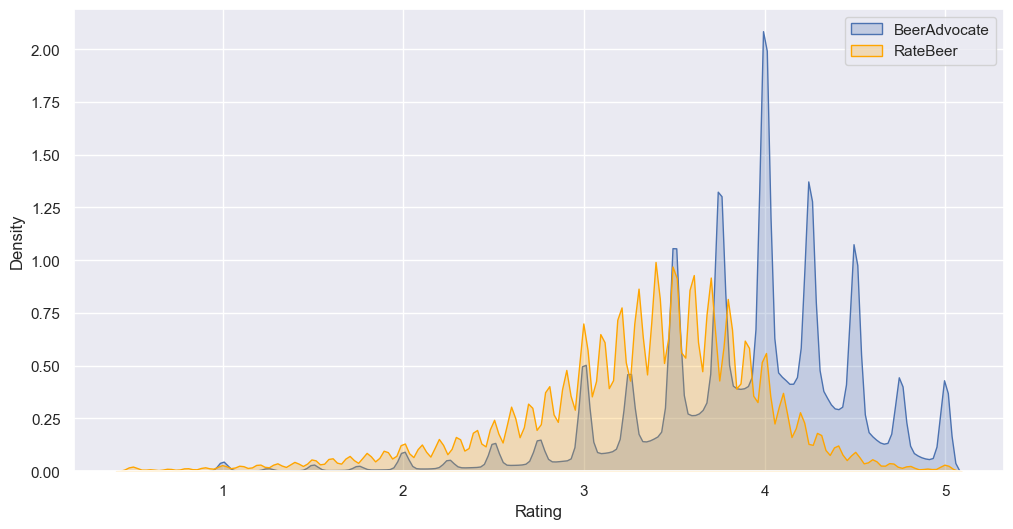

In [12]:
plt.figure(figsize=(12, 6))
plt.ylabel('Density')
plt.xlabel('Rating')
sns.kdeplot(data=df_ba_ratings, x='rating', label='BeerAdvocate', fill=True)
sns.kdeplot(data=df_rb_ratings, x='rating', label='RateBeer', color='orange', fill=True)
plt.legend()
plt.show()

*Interpretation*: These two curves show the distribution of ratings for our two websites RateBeer and BeerAdvocate. First thing that we notice is that these two curves are wavy and are pretty different. We thus understand that ratings from the two websites should not be compared. To understand the difference in these two curves we will look the way each websites provides his ratings. 
In BeerAdvocate, the minimum grade we can give in each category is 1 and the maximum is 5. Ratings are rounded to the second decimal figure.
For RateBeer, the minimum is 0.5 and the maximum is 5. Ratings are rounded to the first decimal figure. 
This explains why the RateBeer waves have less amplitude. Number of possible ratings are less numerous, thus the occurence of each one is more uniform. On the other side BeerAdvocate possible ratings are way bigger, and some are statistically less frequent than others, creating these huge amplitude waves concentrated around multiples of 0.25. This statistical concentration can be explained as many users are encline to give interger ratings, thus concentrating values around our multiples of 0.25. 

# 4. Notion of expert

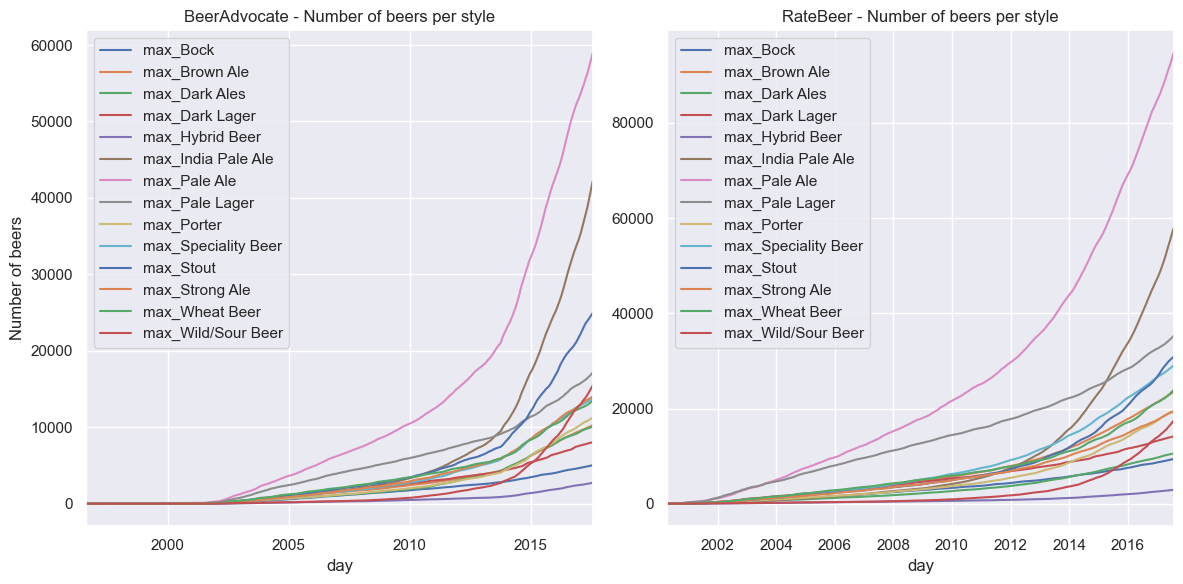

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title("BeerAdvocate - Number of beers per style")
axs[1].set_title("RateBeer - Number of beers per style")
axs[0].set_xlabel("Day")
axs[1].set_xlabel("Day")
axs[0].set_ylabel("Number of beers")

df_ba_current_beer_per_style.plot(x="day", ax=axs[0])
df_rb_current_beer_per_style.plot(x="day", ax=axs[1])

plt.tight_layout()
plt.show()

*Interpretation*: This double lineplot shows the increase in total number of available beer to rate for each beer style.

\begin{equation}
K_{L,i}(t,u) = \sqrt[3]{\frac{|\mathcal{S}_{i}(t,u)|}{|\mathcal{S}_i(t)|}}
\end{equation}

\begin{equation}
K_{G}(t,u) = \frac{|\mathcal{S}(t,u)|}{|\mathcal{S}|} \cdot \frac{\log(1 + \overline{|\mathcal{S}_{i}(t,u)|})}{\log(1 + \overline{|\mathcal{S}_i(t)|})}
\end{equation}

\begin{equation}
K(t,u) = \frac{K_{G}(t,u) + max_{i}(K_{L,i}(t,u))}{2}
\end{equation}

where:
- $|\mathcal{S}_{i}(t,u)|$ is the number of beer tried by user u in style i at time t
- $|\mathcal{S}_i(t)|$ is the number of beer available to rate in style i at time t
- $|\mathcal{S}(t,u)|$ is the number of style tried by user u at time t
- $|\mathcal{S}|$ is the total number of style
- $\overline{|\mathcal{S}_{i}(t,u)|}$ is the mean number of beers tried by style for user u at time t
- $\overline{|\mathcal{S}_i(t)|}$ is the mean number of availble beers by style at time t
- $K_{L,i}(t,u)$ is the local knowledge of user u in style i at time t
- $K_{G}(t,u)$ is the global knowledge of user u at time t
- $K(t,u)$ is the knowledge of user u at time t

In [14]:
(
    df_ba_user_beer_style_past_ratings,
    df_ba_knowledge,
    df_ba_local_knowledge,
    ba_max_columns,
) = add_all_knowledge(df_ba_user_beer_style_past_ratings, df_ba_current_beer_per_style)

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/story/beer_knowledge.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knowledge.loc[:, "knowledge"] = (


In [15]:
(
    df_rb_user_beer_style_past_ratings,
    df_rb_knowledge,
    df_rb_local_knowledge,
    rb_max_columns,
) = add_all_knowledge(df_rb_user_beer_style_past_ratings, df_rb_current_beer_per_style)

/Users/martinlebras/Documents/Cours/EPFL/Projets/ada-2024-project-pdfromscratch/src/utils/story/beer_knowledge.py:218: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_knowledge.loc[:, "knowledge"] = (


In [16]:
df_ba_prime_knowledge = (
    df_ba_knowledge[["user_id", "global_knowledge", "local_knowledge", "knowledge"]]
    .groupby("user_id")
    .max()
    .reset_index()
)
df_rb_prime_knowledge = (
    df_rb_knowledge[["user_id", "global_knowledge", "local_knowledge", "knowledge"]]
    .groupby("user_id")
    .max()
    .reset_index()
)

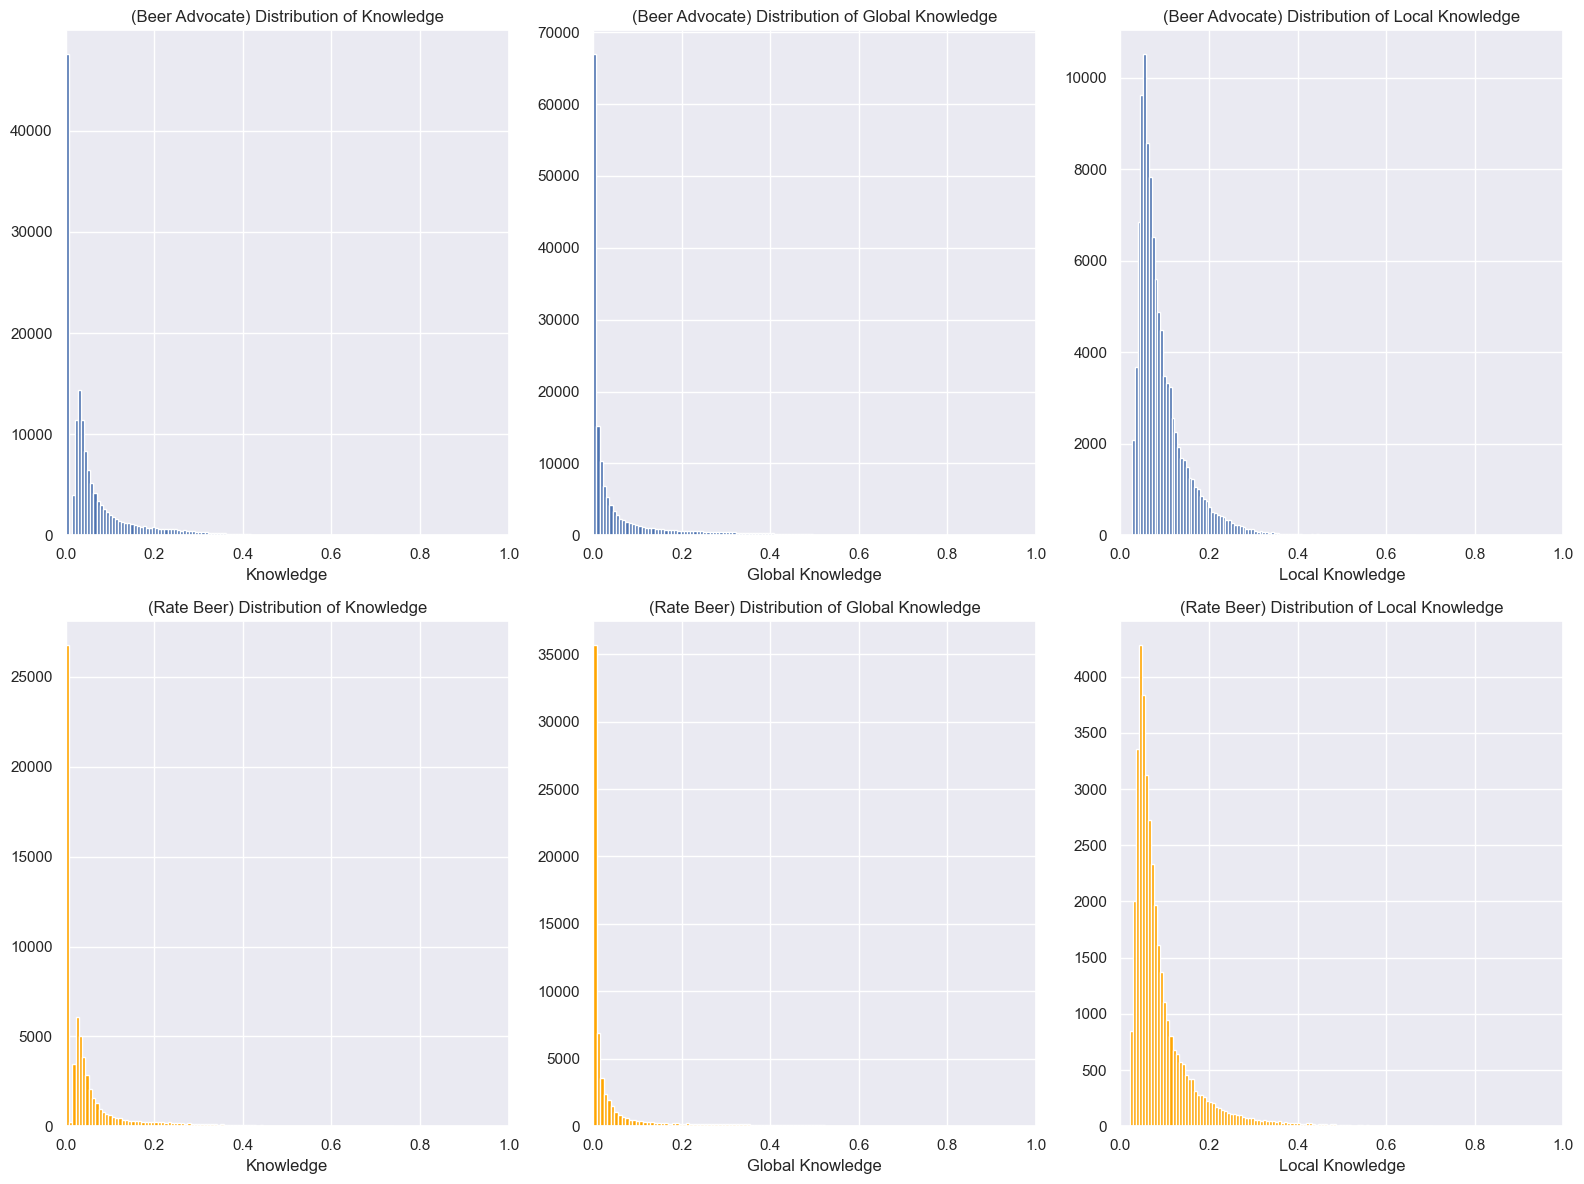

In [17]:
fig, axs = plt.subplots(2, 3, figsize=(16, 12))
axs = axs.ravel()

axs[0].set_title("(Beer Advocate) Distribution of Knowledge")
axs[0].set_xlabel("Knowledge")
axs[0].set_xlim([0, 1])

axs[1].set_title("(Beer Advocate) Distribution of Global Knowledge")
axs[1].set_xlabel("Global Knowledge")
axs[1].set_xlim([0, 1])

axs[2].set_title("(Beer Advocate) Distribution of Local Knowledge")
axs[2].set_xlabel("Local Knowledge")
axs[2].set_xlim([0, 1])

axs[3].set_title("(Rate Beer) Distribution of Knowledge")
axs[3].set_xlabel("Knowledge")
axs[3].set_xlim([0, 1])

axs[4].set_title("(Rate Beer) Distribution of Global Knowledge")
axs[4].set_xlabel("Global Knowledge")
axs[4].set_xlim([0, 1])

axs[5].set_title("(Rate Beer) Distribution of Local Knowledge")
axs[5].set_xlabel("Local Knowledge")
axs[5].set_xlim([0, 1])

df_ba_prime_knowledge["knowledge"].hist(bins=100, ax=axs[0])
df_ba_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[1])
df_ba_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[2])

df_rb_prime_knowledge["knowledge"].hist(bins=100, ax=axs[3], color="orange")
df_rb_prime_knowledge["global_knowledge"].hist(bins=100, ax=axs[4], color="orange")
df_rb_prime_knowledge["local_knowledge"].hist(bins=100, ax=axs[5], color="orange")

plt.tight_layout()
plt.show()

*Interpretation*: This is the distribution of the maximum Knowledge, Global Knowledge and Best Style Local Knowledge reached by each user. They all seem to follow a powerlaw altough the Global Knowledge and Knowledge have a massive peak in 0 due to the user giving their first rating and therefore without any previous knowledge.

In [18]:
# Save memory
del df_ba_prime_knowledge
del df_rb_prime_knowledge

In [19]:
df_ba_highest_global_knowledge = df_ba_knowledge.loc[
    df_ba_knowledge[["user_id", "global_knowledge"]]
    .groupby("user_id")
    .idxmax()
    .reset_index()["global_knowledge"]
]
df_rb_highest_global_knowledge = df_rb_knowledge.loc[
    df_rb_knowledge[["user_id", "global_knowledge"]]
    .groupby("user_id")
    .idxmax()
    .reset_index()["global_knowledge"]
]

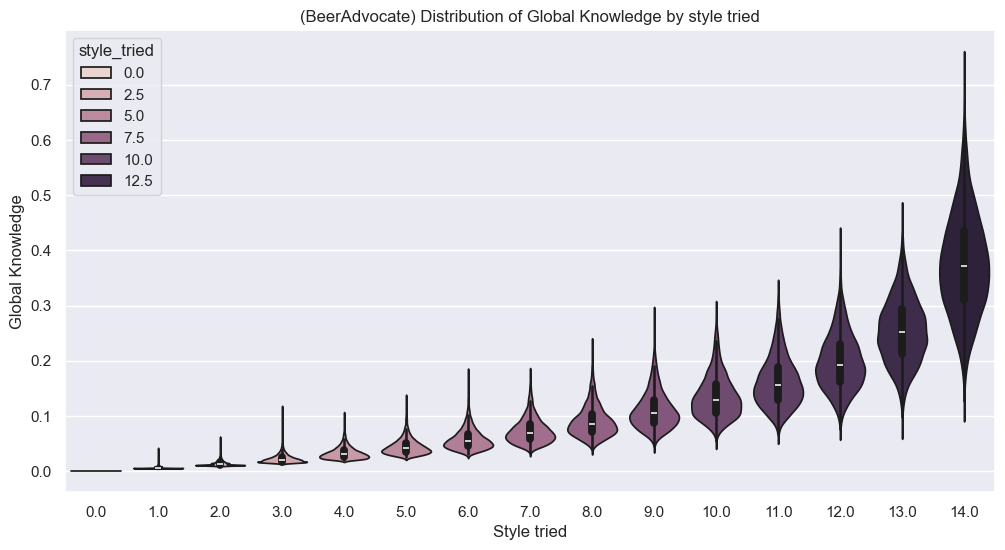

In [20]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Distribution of Global Knowledge by style tried")
plt.xlabel("Style tried")
plt.ylabel("Global Knowledge")
sns.violinplot(
    x=df_ba_highest_global_knowledge["style_tried"],
    y=df_ba_highest_global_knowledge["global_knowledge"],
    hue=df_ba_highest_global_knowledge["style_tried"],
)
plt.show()

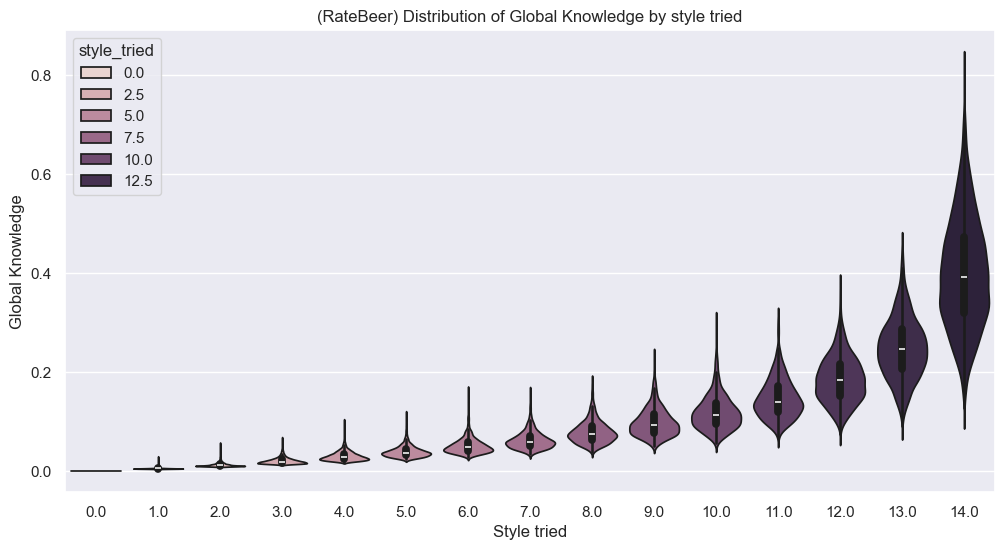

In [21]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Distribution of Global Knowledge by style tried")
plt.xlabel("Style tried")
plt.ylabel("Global Knowledge")
sns.violinplot(
    x=df_rb_highest_global_knowledge["style_tried"],
    y=df_rb_highest_global_knowledge["global_knowledge"],
    hue=df_rb_highest_global_knowledge["style_tried"],
)
plt.show()

*Interpretation*: This plot shows the distribution of the highest Global Knowledge reached by each user split on the number of style tried at the time. It shows that there is indeed a strong link between a high number of style tried and a high Global Knowledge due to the formula used but users can still reach relatively high levels even with less style tried.

In [22]:
# Save memory
del df_ba_highest_global_knowledge
del df_rb_highest_global_knowledge

### Local knowledge

In [23]:
df_ba_prime_local_knowledge = (
    df_ba_local_knowledge.iloc[:, :-2].groupby("user_id").max().reset_index()
)
df_rb_prime_local_knowledge = (
    df_rb_local_knowledge.iloc[:, :-2].groupby("user_id").max().reset_index()
)

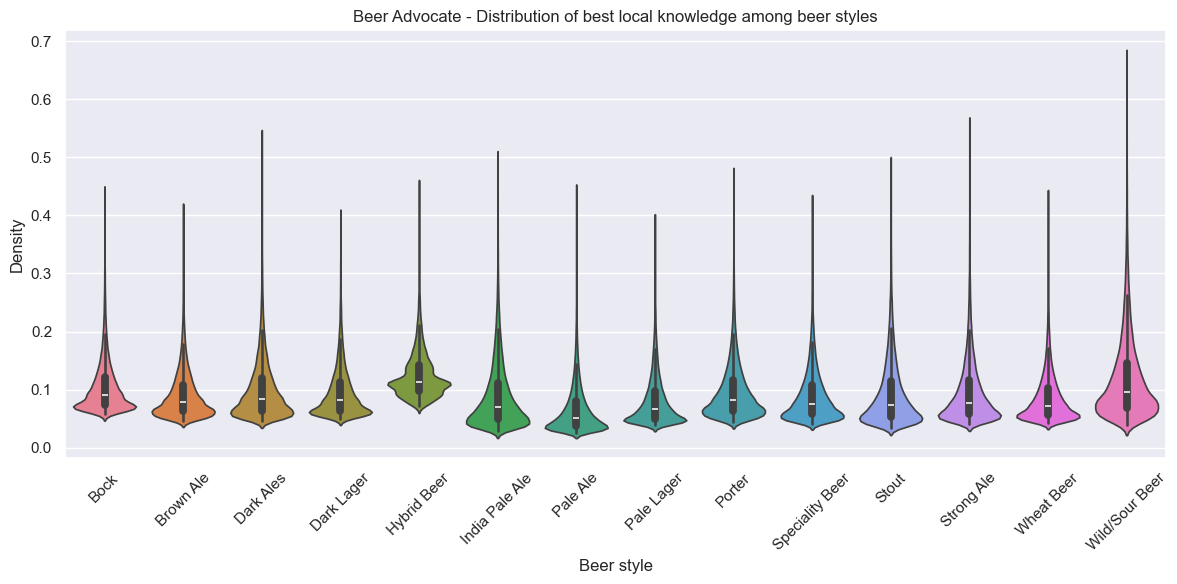

In [24]:
plt.figure(figsize=(12, 6))
plt.title("Beer Advocate - Distribution of best local knowledge among beer styles")
plt.xlabel("Beer style")
plt.ylabel("Density")
sns.violinplot(df_ba_prime_local_knowledge.iloc[:, 1:].replace(0, np.nan))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

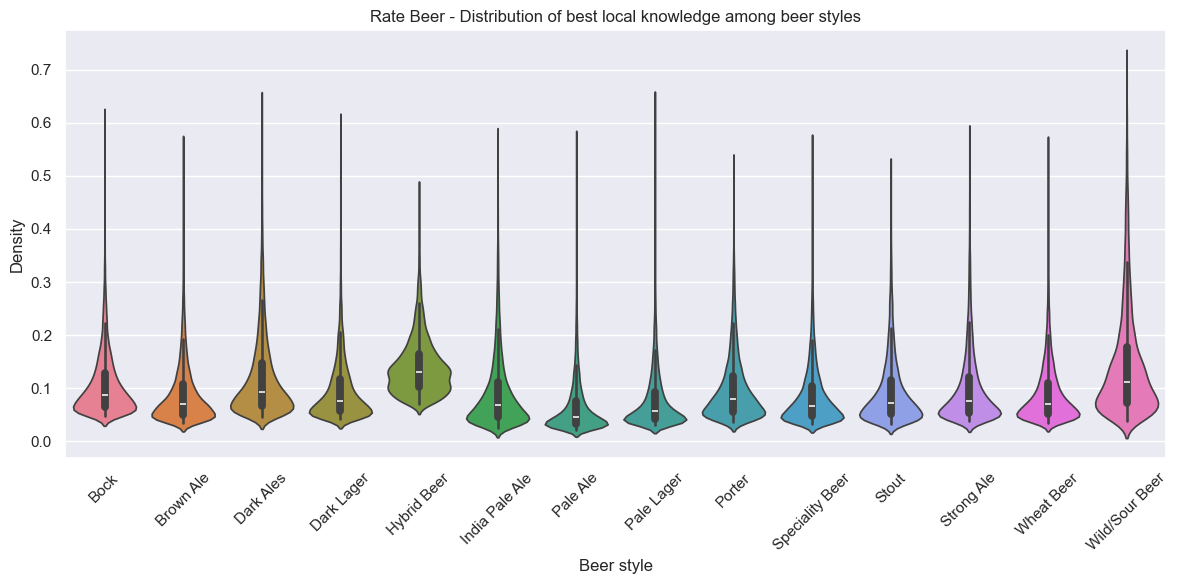

In [25]:
plt.figure(figsize=(12, 6))
plt.title("Rate Beer - Distribution of best local knowledge among beer styles")
plt.xlabel("Beer style")
plt.ylabel("Density")
sns.violinplot(df_rb_prime_local_knowledge.iloc[:, 1:].replace(0, np.nan))
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

*Interpretation*: These plots show the distribution of the highest local knowledge reached by user for each beer style. For all styles on each websites, the distribution are positively skewed highlighting the difficulty to reach high level of local knowledge. Nonetheless, some variations are observed between the styles due to the number of users who tried them or the number of beers available.

In [26]:
# Save memory
del df_ba_prime_local_knowledge
del df_rb_prime_local_knowledge

### Experts

In [27]:
df_ba_user_beer_style_past_ratings, df_ba_local_knowledge_quantile_expert = add_experts(
    df_ba_local_knowledge, df_ba_user_beer_style_past_ratings, 0.90
)
df_rb_user_beer_style_past_ratings, df_rb_local_knowledge_quantile_expert = add_experts(
    df_rb_local_knowledge, df_rb_user_beer_style_past_ratings, 0.90
)

df_ba_user_beer_style_past_ratings, df_ba_local_knowledge_quantile_novice = add_novices(
    df_ba_local_knowledge, df_ba_user_beer_style_past_ratings, 0.10
)
df_rb_user_beer_style_past_ratings, df_rb_local_knowledge_quantile_novice = add_novices(
    df_rb_local_knowledge, df_rb_user_beer_style_past_ratings, 0.10
)

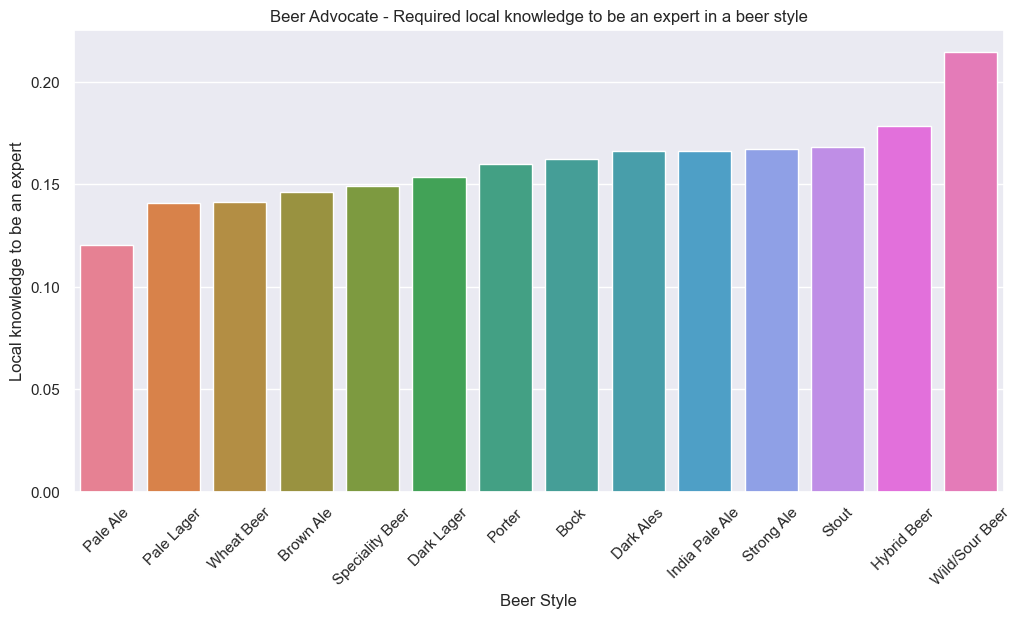

In [28]:
plt.figure(figsize=(12, 6))
plt.title("Beer Advocate - Required local knowledge to be an expert in a beer style")
plt.xlabel("Beer Style")
plt.ylabel("Local knowledge to be an expert")
sns.barplot(
    x=df_ba_local_knowledge_quantile_expert.sort_values().index,
    y=df_ba_local_knowledge_quantile_expert.sort_values(),
    hue=df_ba_local_knowledge_quantile_expert.sort_values().index,
)
plt.xticks(rotation=45)
plt.show()

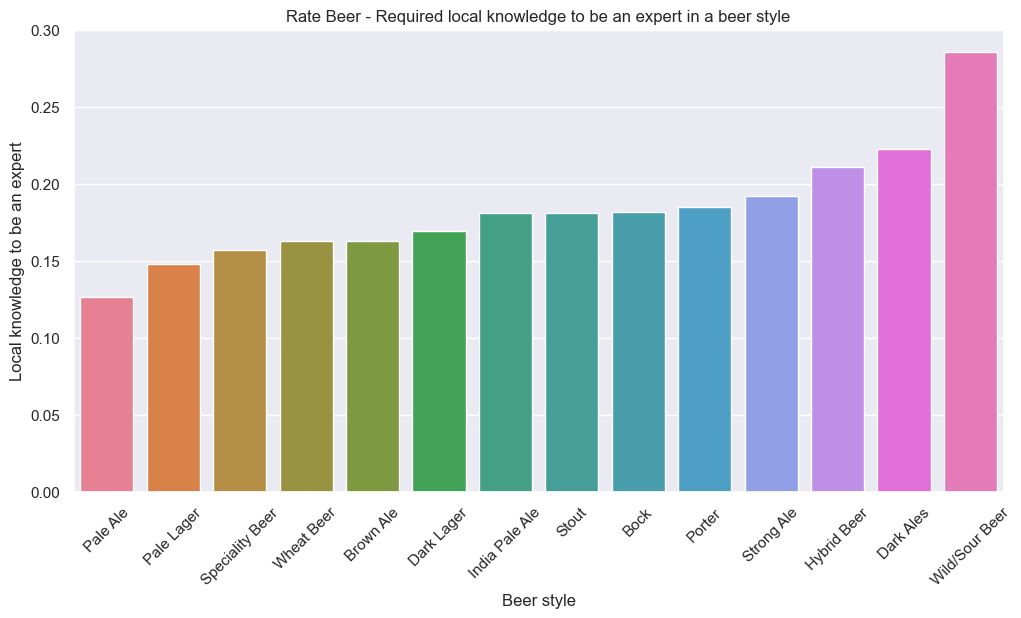

In [29]:
plt.figure(figsize=(12, 6))
plt.title("Rate Beer - Required local knowledge to be an expert in a beer style")
plt.xlabel("Beer style")
plt.ylabel("Local knowledge to be an expert")
sns.barplot(
    x=df_rb_local_knowledge_quantile_expert.sort_values().index,
    y=df_rb_local_knowledge_quantile_expert.sort_values(),
    hue=df_rb_local_knowledge_quantile_expert.sort_values().index,
)
plt.xticks(rotation=45)
plt.show()

*Interpretation*: These barplots show the local knowledge to reach in each beer style to be considered an expert as defined by the top 10% users in the best local knowledge distribution. The threshold is clearly not the same between beer styles due to the number of users and beers as mentioned earlier but the same tendencies are observed across the two websites : Wild/Sour first and Pale Ale last.

In [30]:
df_ba_beer_required_to_be_expert_long = get_beer_required_expert(
    df_ba_user_beer_style_past_ratings,
    df_ba_local_knowledge_quantile_expert,
    ba_max_columns,
)
df_rb_beer_required_to_be_expert_long = get_beer_required_expert(
    df_rb_user_beer_style_past_ratings,
    df_rb_local_knowledge_quantile_expert,
    rb_max_columns,
)

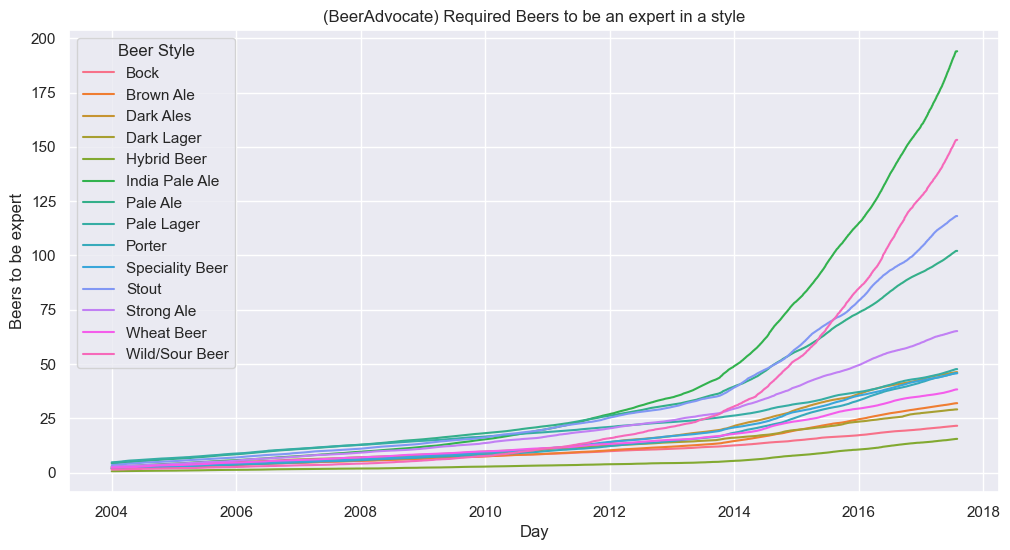

In [31]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(
    x=df_ba_beer_required_to_be_expert_long["day"],
    y=df_ba_beer_required_to_be_expert_long["Beers to be expert"],
    hue=df_ba_beer_required_to_be_expert_long["Beer Style"],
)
plt.show()

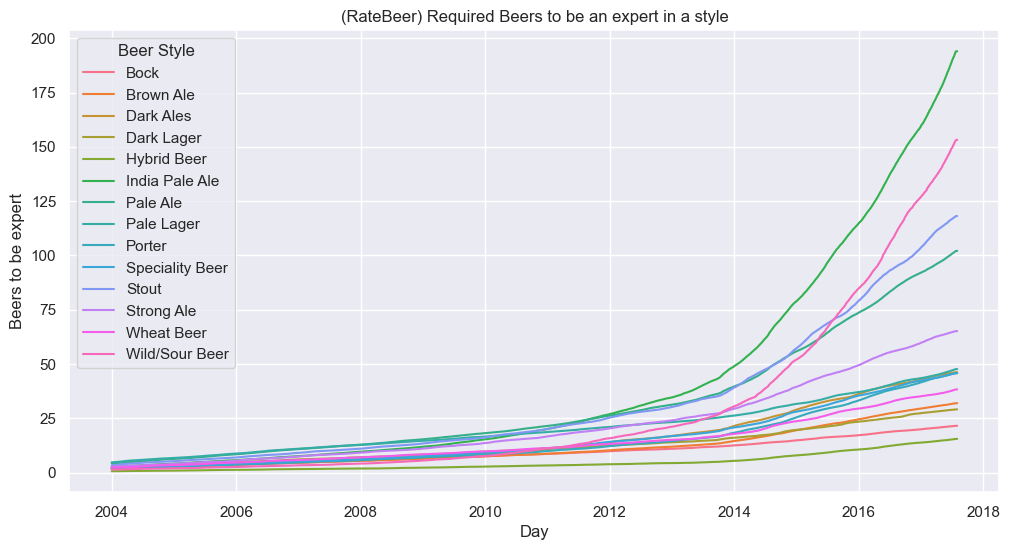

In [32]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Required Beers to be an expert in a style")
plt.xlabel("Day")
plt.ylabel("Beers to be expert")
sns.lineplot(
    x=df_ba_beer_required_to_be_expert_long["day"],
    y=df_ba_beer_required_to_be_expert_long["Beers to be expert"],
    hue=df_ba_beer_required_to_be_expert_long["Beer Style"],
)
plt.show()

*Interpretation*: Although the local knowledge threshold is a set value, the local knowledge itself depends on the number of available beers in each beer style. Therefore the number of beer to rate to be considered an expert evolves as the number of available beers increases. Because of this phenomenon a user who became an expert but stopped rating beer from their style of expertise can lose their status.

In [33]:
df_ba_expert_users, df_ba_count_exp, ba_expert_columns = get_expert_count(
    df_ba_user_beer_style_past_ratings, df_ba_users
)
df_rb_expert_users, df_rb_count_exp, rb_expert_columns = get_expert_count(
    df_rb_user_beer_style_past_ratings, df_rb_users
)
df_ba_novice_users, df_ba_count_exp, ba_novice_columns = get_novice_count(
    df_ba_user_beer_style_past_ratings, df_ba_users
)
df_rb_novice_users, df_rb_count_exp, rb_novice_columns = get_novice_count(
    df_rb_user_beer_style_past_ratings, df_rb_users
)

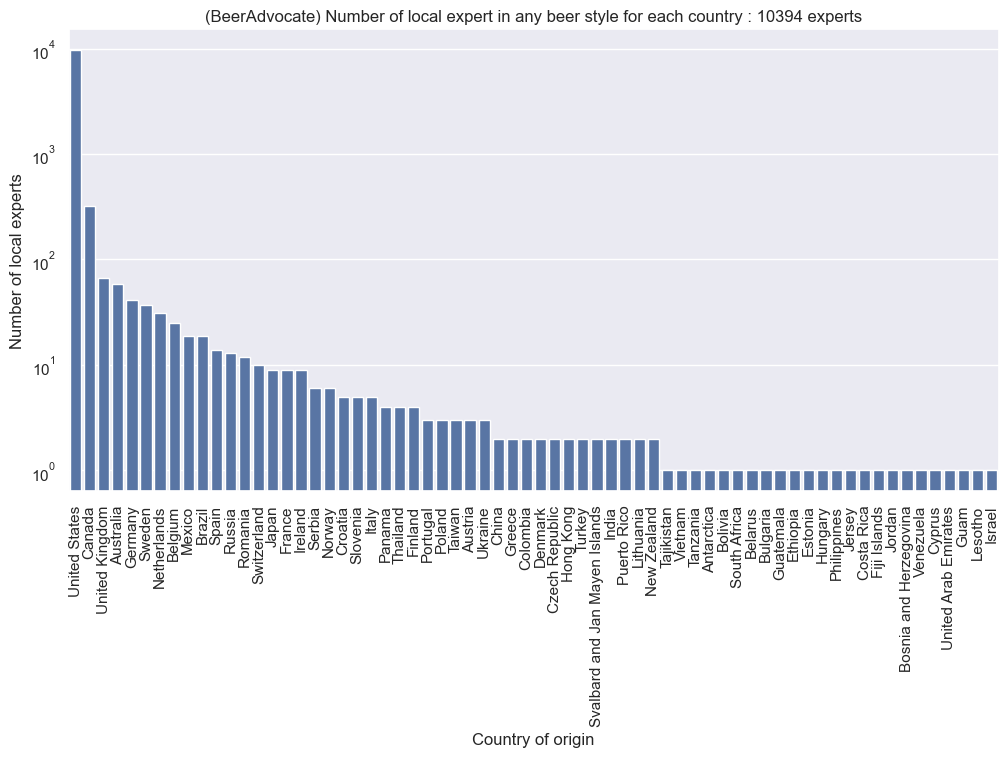

In [34]:
plt.figure(figsize=(12, 6))
sns.barplot(df_ba_expert_users["user_country"].value_counts())
plt.xticks(rotation=90)
plt.title(
    f"(BeerAdvocate) Number of local expert in any beer style for each country : {df_ba_expert_users["user_country"].value_counts().sum().item()} experts"
)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

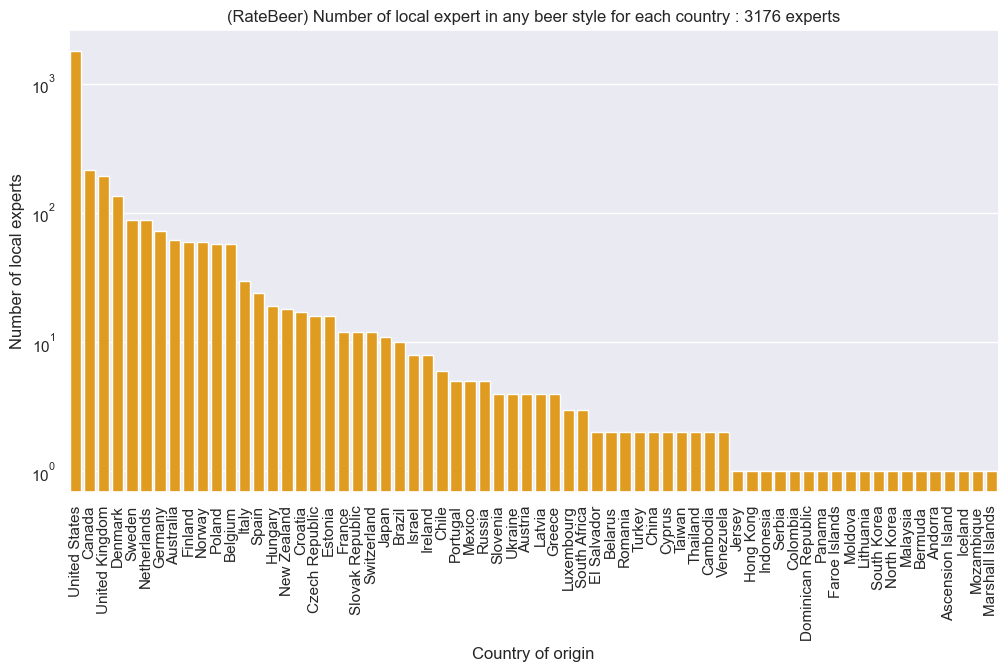

In [35]:
plt.figure(figsize=(12, 6))
sns.barplot(df_rb_expert_users["user_country"].value_counts(), color="orange")
plt.xticks(rotation=90)
plt.title(
    f"(RateBeer) Number of local expert in any beer style for each country : {df_rb_expert_users["user_country"].value_counts().sum().item()} experts"
)
plt.xlabel("Country of origin")
plt.ylabel("Number of local experts")
plt.yscale("log")
plt.show()

*Interpretaton*: Those ber charts depicts the number of unique users who are expert in any style in each country. There is a clear domination of the United States on both websites followed by the Canada and the United Kindom on both websites. The surprising part comes from the other side of the plot where we can find some interesting territories with at least an expert such as Ascension Island or the Marshall Islands on Rate Beer and Svalbard or the Antarctica on Beer Advocate.

In [36]:
fig = px.choropleth(
    df_ba_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis,
)
fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type="mercator"),
)
fig.show()

In [37]:
fig = px.choropleth(
    df_rb_count_exp,
    locations="user_country_code",
    color="log_count",
    hover_name="user_country_code",
    hover_data="count",
    color_continuous_scale=px.colors.sequential.Viridis,
)

fig.update_layout(
    margin=dict(l=0, r=0, t=0, b=0),
    geo=dict(showframe=False, showcoastlines=True, projection_type="mercator"),
)
fig.show()

*Interpretation*: These maps are geographical representations of the previous bar charts to better illustrate the repartition of the experts

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/2019517806.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/2019517806.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/2019517806.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/2019517806.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/2019517806.py:9: UserWarning:

set_ticklabels() should only be used with a fixed number

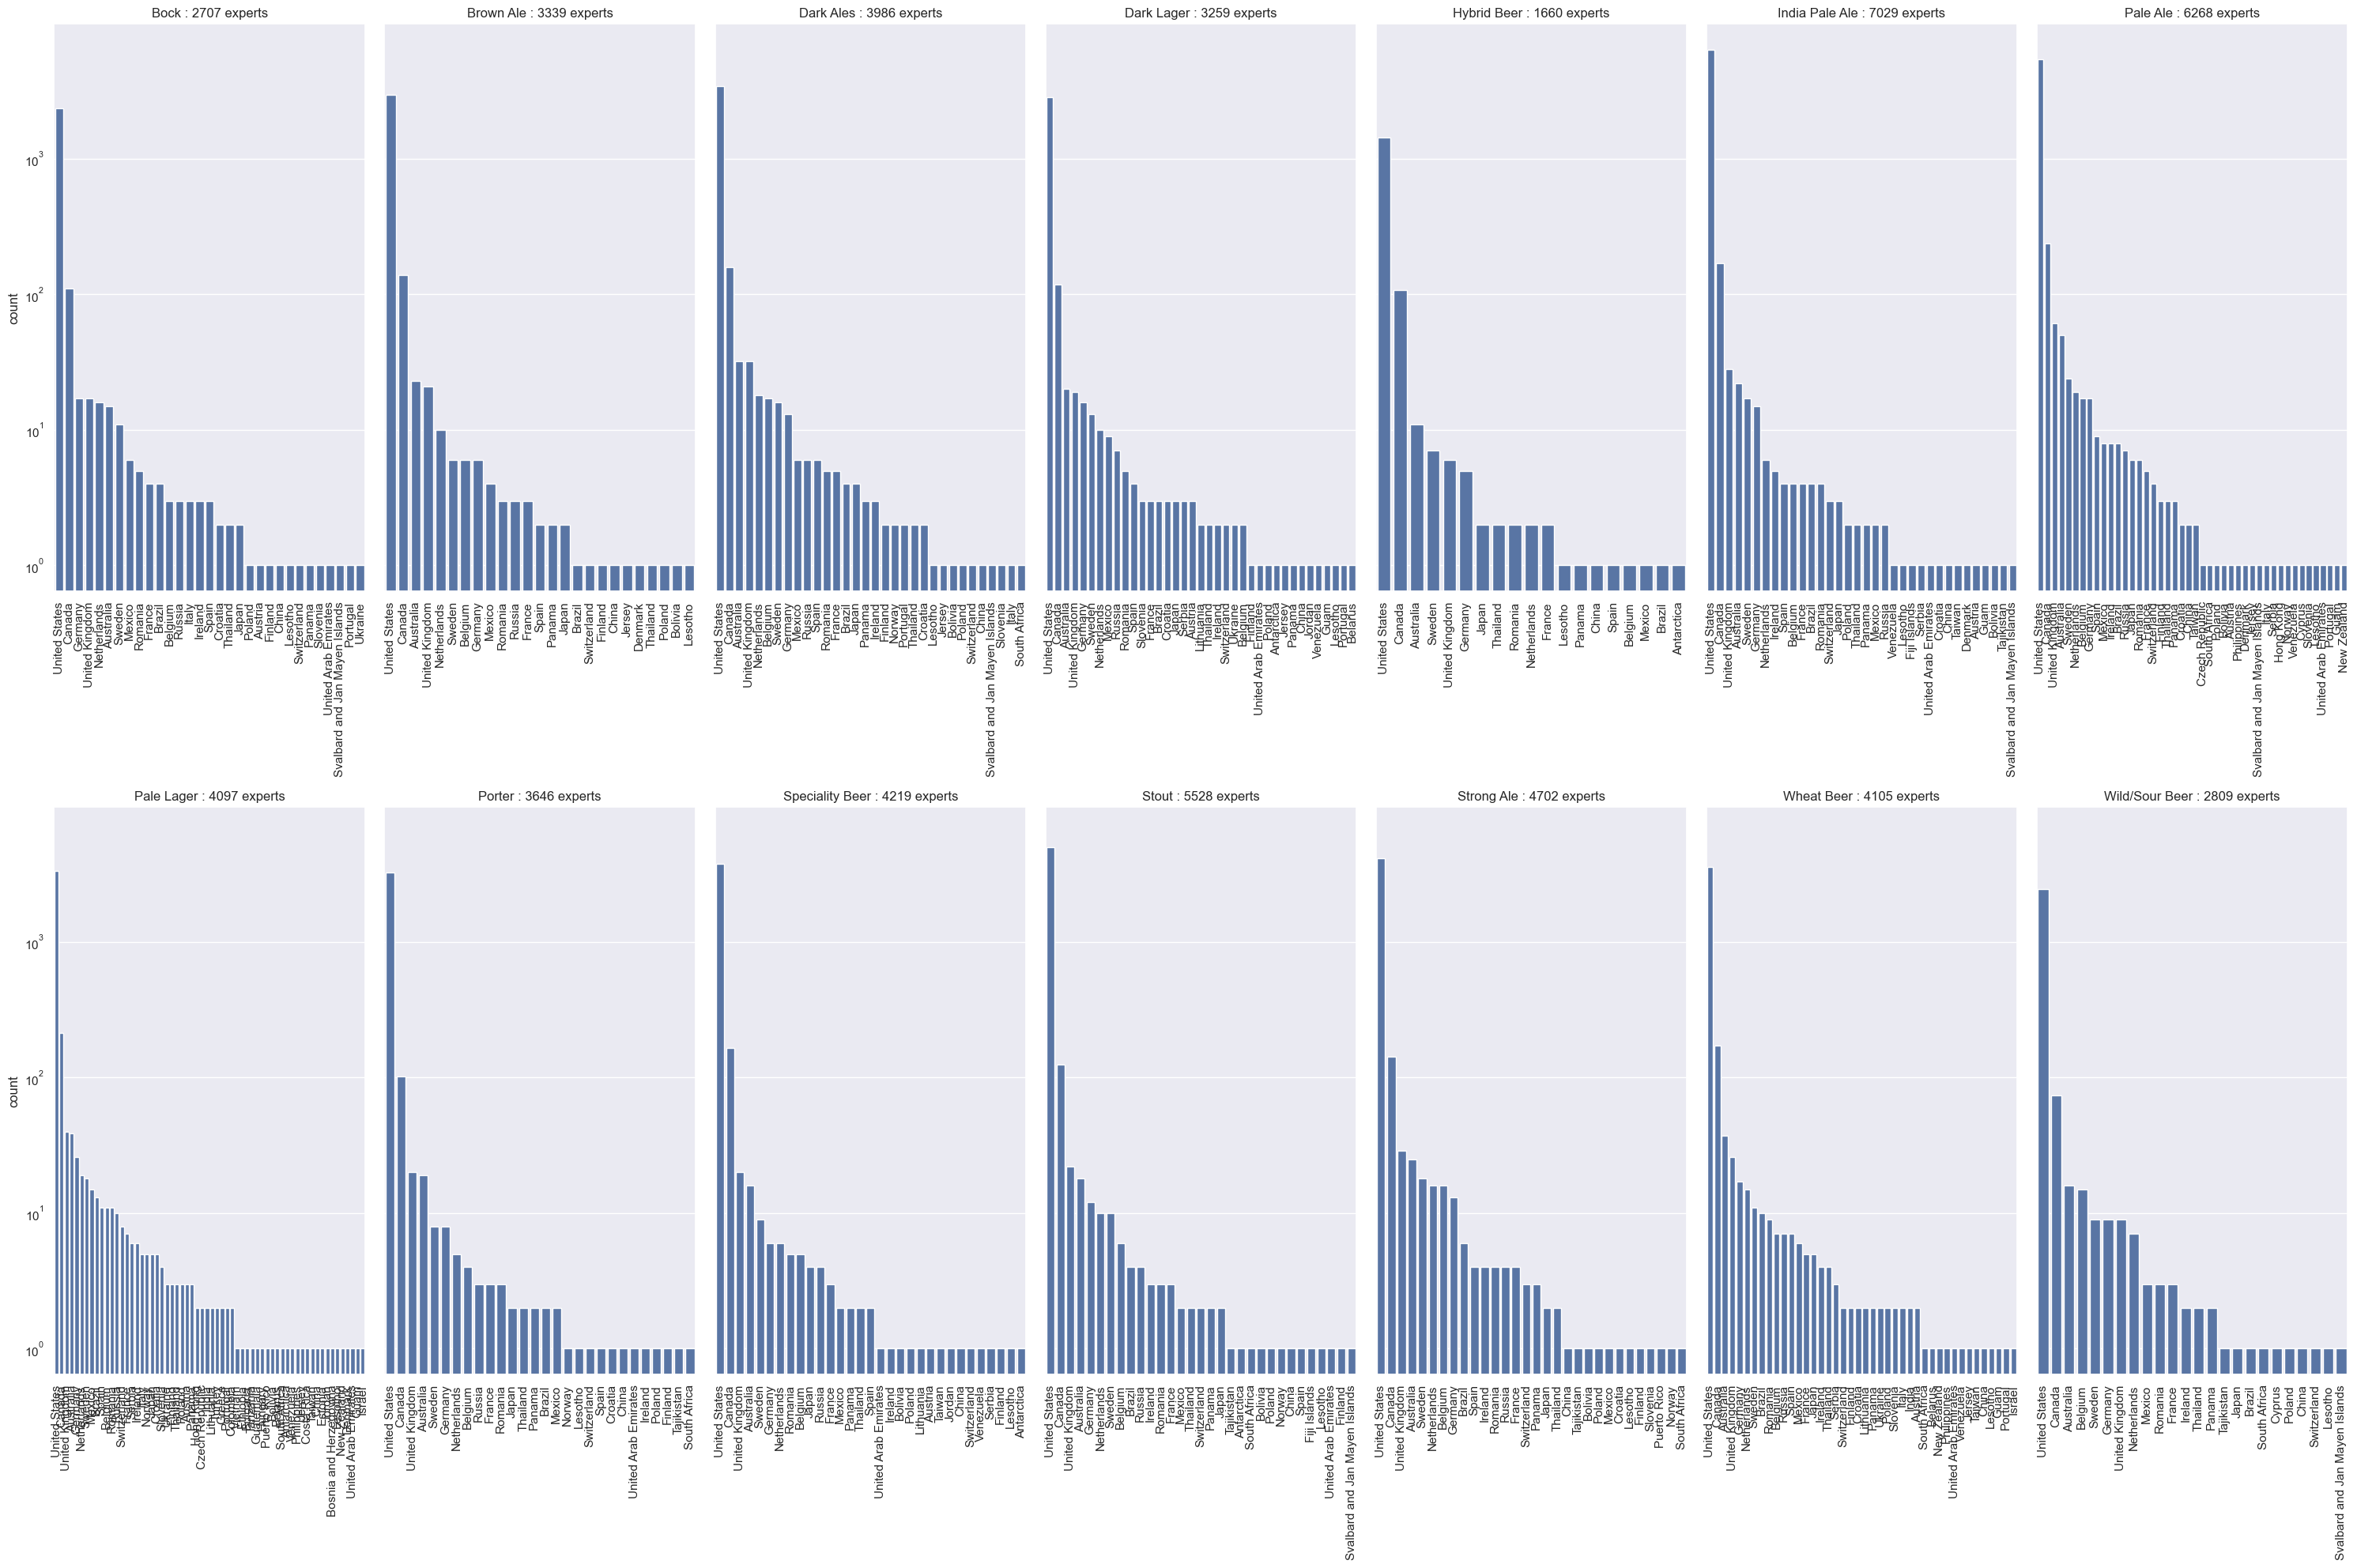

In [38]:
fig, axes = plt.subplots(2, 7, figsize=(30, 20), sharey=True)

for col_idx, col in enumerate(ba_expert_columns):
    sns.barplot(
        df_ba_expert_users[df_ba_expert_users[col] == 1]["user_country"].value_counts(),
        ax=axes[col_idx // 7, col_idx % 7],
    )
    # axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx // 7, col_idx % 7].set_xticklabels(
        axes[col_idx // 7, col_idx % 7].get_xticklabels(), rotation=90
    )
    axes[col_idx // 7, col_idx % 7].set_xlabel("")
    # plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx // 7, col_idx % 7].set_title(
        f"{col.split("_")[0]} : {df_ba_expert_users[col].sum()} experts"
    )
    axes[col_idx // 7, col_idx % 7].set_yscale("log")

plt.tight_layout()
plt.show()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/4240173850.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/4240173850.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/4240173850.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/4240173850.py:10: UserWarning:

set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/4240173850.py:10: UserWarning:

set_ticklabels() should only be used with a fixed n

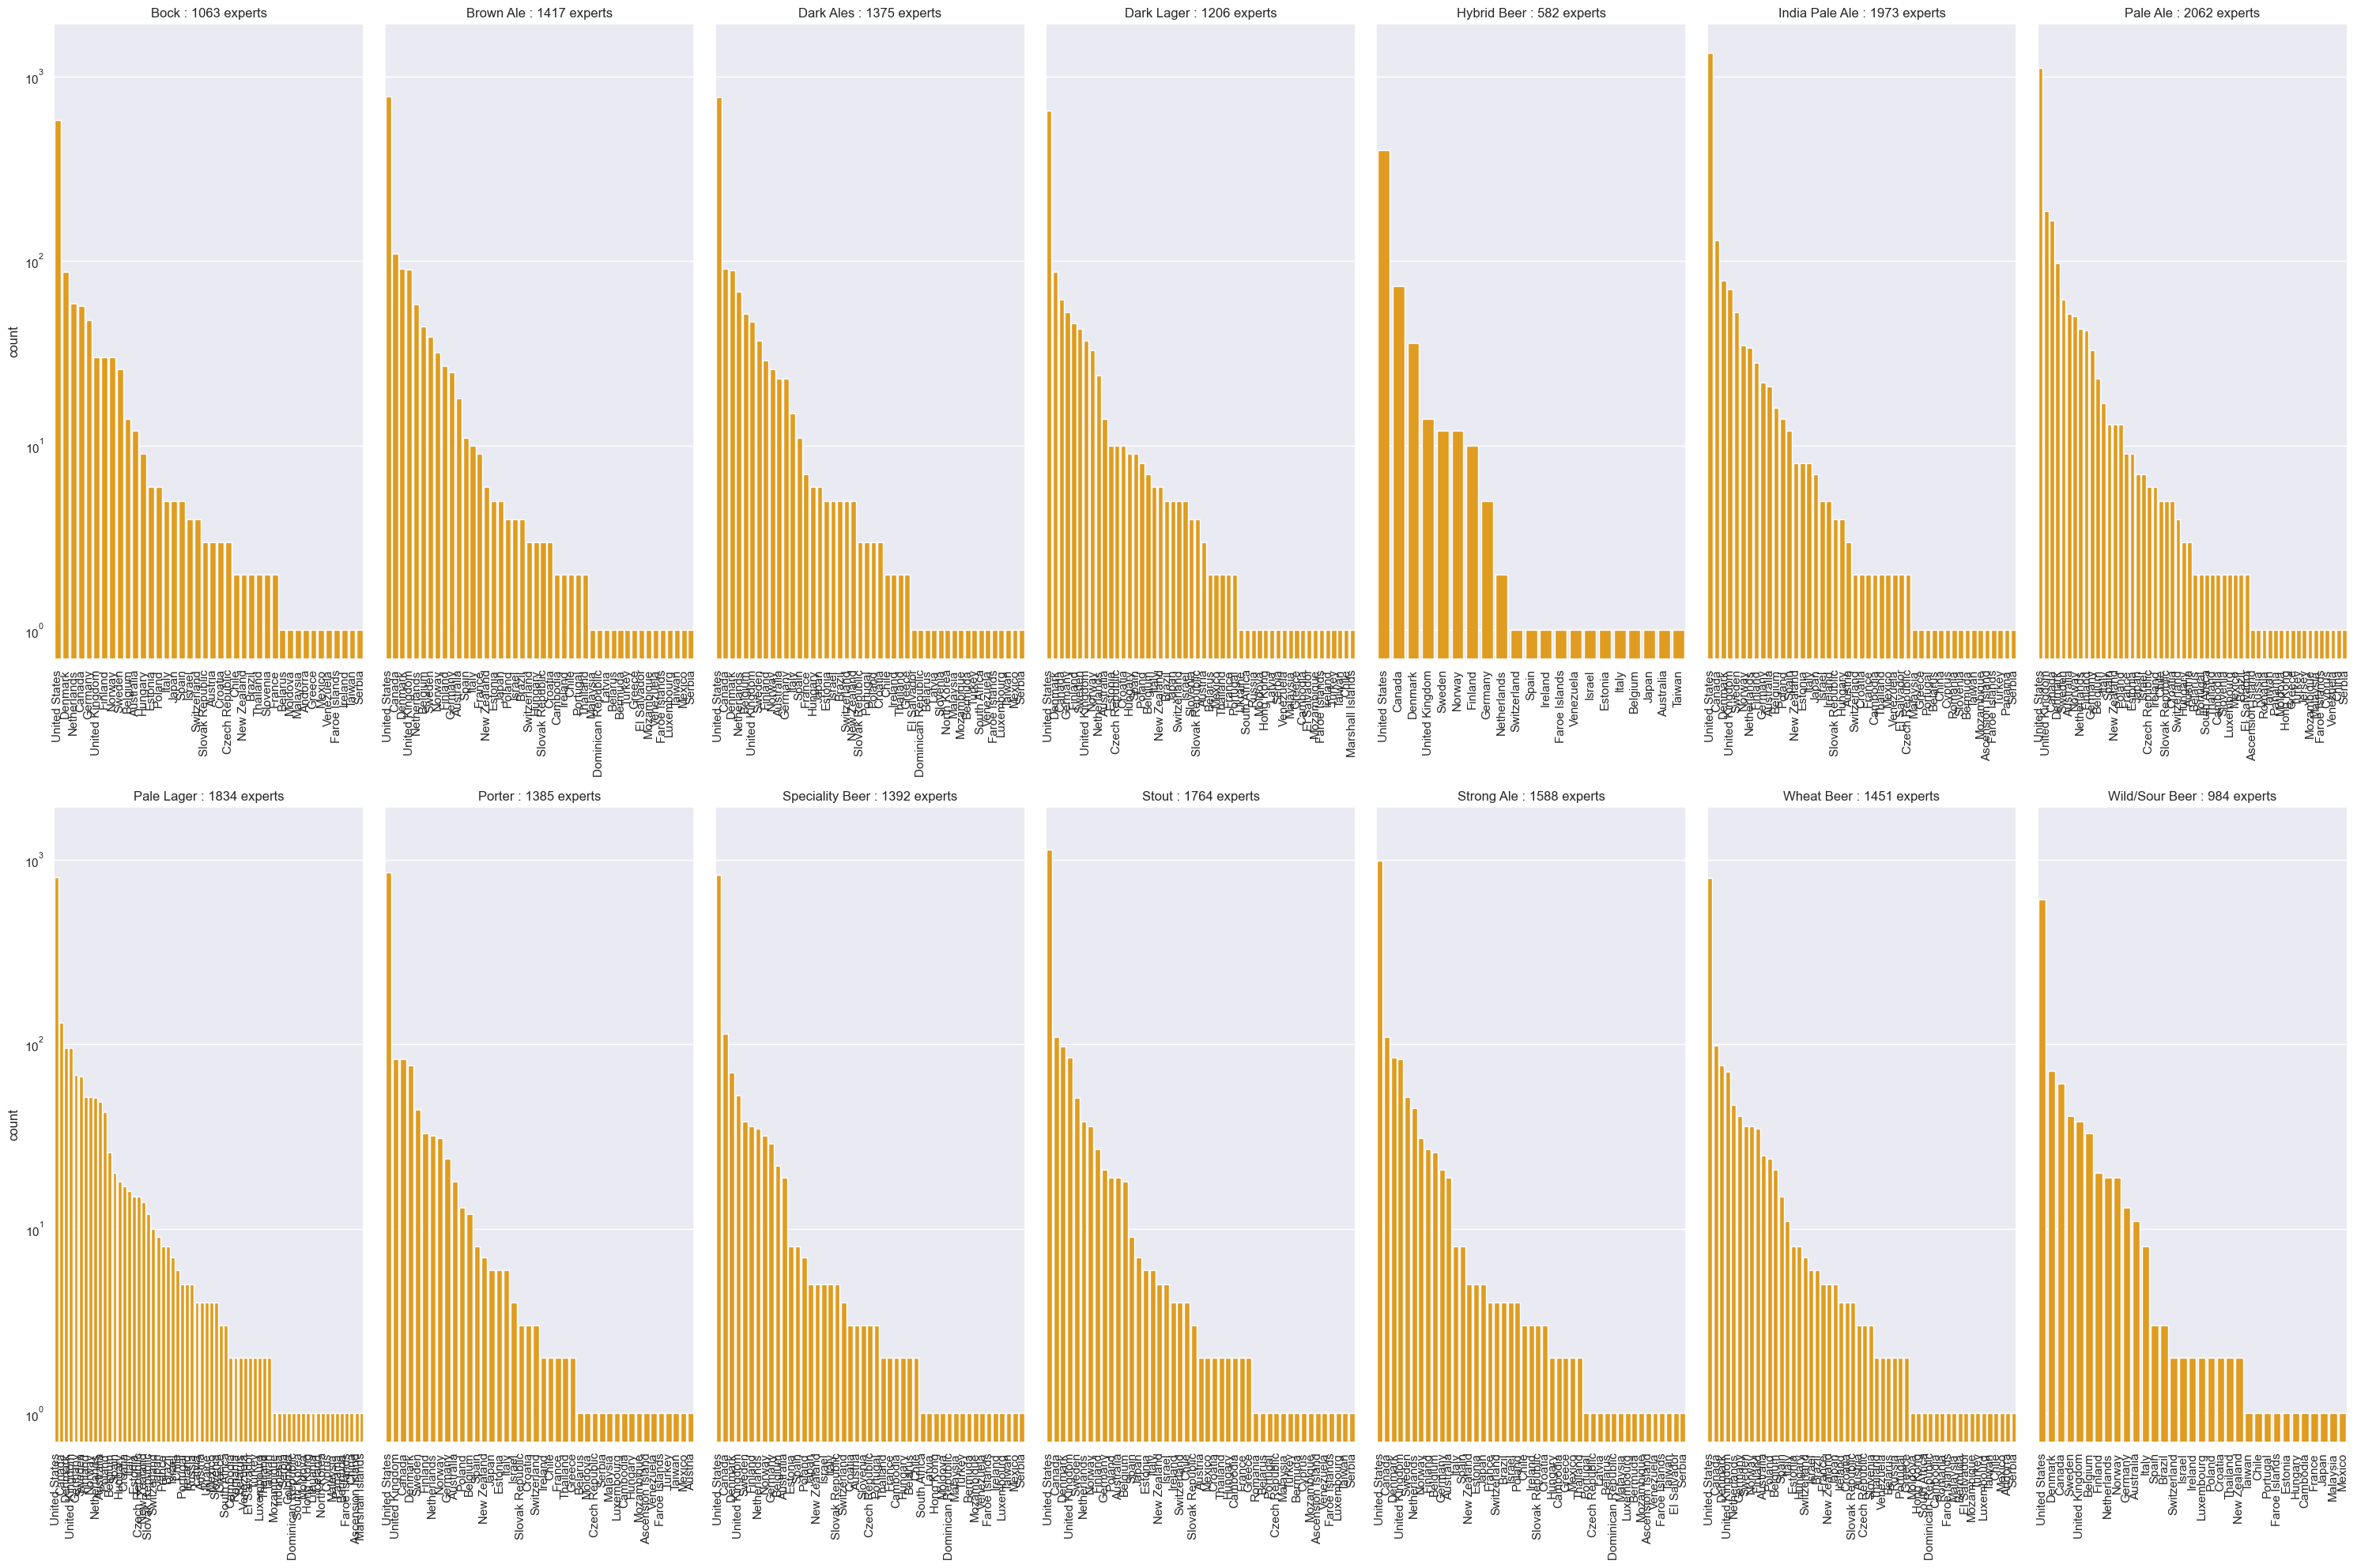

In [39]:
fig, axes = plt.subplots(2, 7, figsize=(30, 20), sharey=True)

for col_idx, col in enumerate(rb_expert_columns):
    sns.barplot(
        df_rb_expert_users[df_rb_expert_users[col] == 1]["user_country"].value_counts(),
        ax=axes[col_idx // 7, col_idx % 7],
        color="orange",
    )
    # axes[col_idx//7,col_idx%7].set_xticklabels(rotation=90)
    axes[col_idx // 7, col_idx % 7].set_xticklabels(
        axes[col_idx // 7, col_idx % 7].get_xticklabels(), rotation=90
    )
    axes[col_idx // 7, col_idx % 7].set_xlabel("")
    # plt.ylabel(f"Number of local experts in {col.split("_")[0]}")
    axes[col_idx // 7, col_idx % 7].set_title(
        f"{col.split("_")[0]} : {df_rb_expert_users[col].sum()} experts"
    )
    axes[col_idx // 7, col_idx % 7].set_yscale("log")

plt.tight_layout()
plt.show()

*Interpretation*: These bar charts shows the number of expert per country for each beer style

In [40]:
df_ba_expert_per_day = (
    df_ba_user_beer_style_past_ratings[ba_expert_columns + ["month", "user_id"]]
    .groupby(["user_id", "month"])
    .max()
    .reset_index()
    .iloc[:, 1:]
    .groupby("month")
    .sum()
    .reset_index()
)
df_ba_expert_per_day_long = df_ba_expert_per_day.melt(
    id_vars="month", var_name="Beer Style", value_name="Number of expert ratings"
)

df_rb_expert_per_day = (
    df_rb_user_beer_style_past_ratings[rb_expert_columns + ["month", "user_id"]]
    .groupby(["user_id", "month"])
    .max()
    .reset_index()
    .iloc[:, 1:]
    .groupby("month")
    .sum()
    .reset_index()
)
df_rb_expert_per_day_long = df_rb_expert_per_day.melt(
    id_vars="month", var_name="Beer Style", value_name="Number of expert ratings"
)

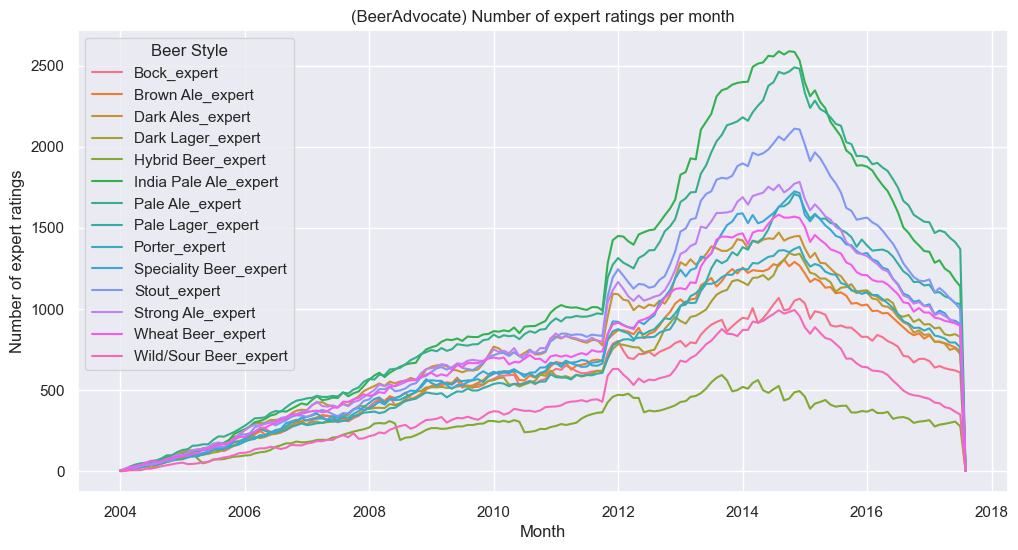

In [41]:
plt.figure(figsize=(12, 6))
plt.title("(BeerAdvocate) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(
    data=df_ba_expert_per_day_long,
    x="month",
    y="Number of expert ratings",
    hue="Beer Style",
)
plt.show()

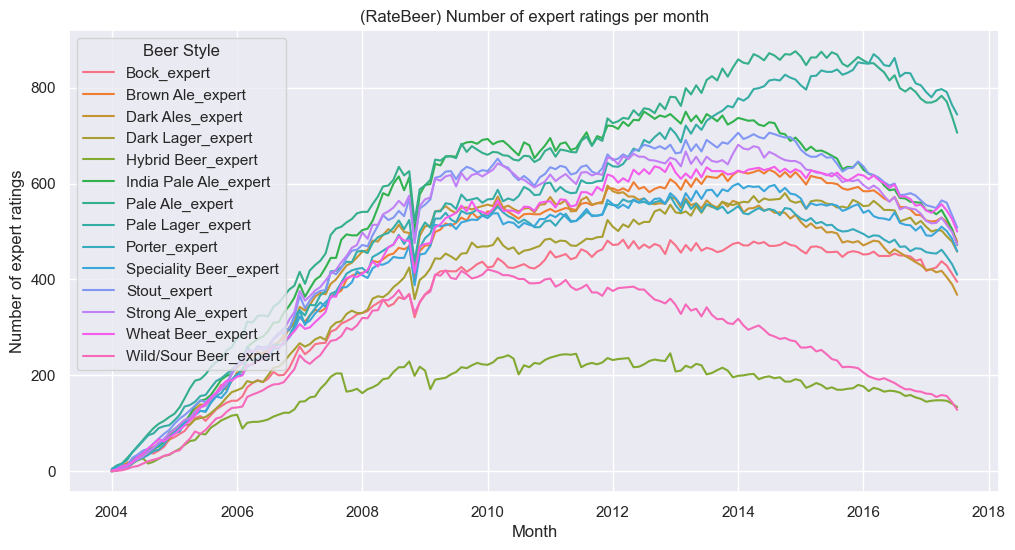

In [42]:
plt.figure(figsize=(12, 6))
plt.title("(RateBeer) Number of expert ratings per month")
plt.xlabel("Month")
plt.ylabel("Number of expert ratings")
sns.lineplot(
    data=df_rb_expert_per_day_long,
    x="month",
    y="Number of expert ratings",
    hue="Beer Style",
)
plt.show()

*Interpretation*: These lineplots display the total number of ratings given by experts users over time in each beer style for Beer Advocate and Rate Beer. The number of experts obviously grows on the first years due to the growing number of overall users on each website.

In [43]:
df_ba_to_barplot = get_expert_vs_novice(
    df_ba_ratings, df_ba_user_beer_style_past_ratings, ba_expert_columns, ba_novice_columns, k=100
)
df_rb_to_barplot = get_expert_vs_novice(
    df_rb_ratings, df_rb_user_beer_style_past_ratings, rb_expert_columns, rb_novice_columns, k=100
)

We will perform T-test and F-Test on the ratings distributions of experts and novices for each beer style in order to asses if the means and the variances are different between those two sets of users. The null hypothesis is a similar mean between experts and novices for the t-test and a similar variance for the f-test

In [44]:
# T-Test for the difference in mean

t_stat_list = []
p_value_list = []
for style in df_ba_to_barplot["beer_global_style"].unique():
    t_stat, p_value = f_oneway(df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 1)]["rating"], df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 0)]["rating"])
    t_stat_list.append(t_stat)
    p_value_list.append(p_value)
df_ba_t_test_exp_nov_mean = pd.DataFrame({"beer_global_style":df_ba_to_barplot["beer_global_style"].unique(),"t_stat":t_stat_list,"p_value":p_value_list})

print(df_ba_t_test_exp_nov_mean)

   beer_global_style       t_stat        p_value
0               Bock    70.217492   5.653136e-17
1          Brown Ale   149.325623   3.166175e-34
2          Dark Ales   300.292696   5.370614e-67
3         Dark Lager    91.767681   1.070830e-21
4        Hybrid Beer    18.495758   1.724187e-05
5     India Pale Ale  4630.230326   0.000000e+00
6           Pale Ale   934.649845  2.559890e-203
7         Pale Lager   165.340937   9.361847e-38
8             Porter   122.986726   1.628803e-28
9    Speciality Beer    13.022140   3.082894e-04
10             Stout   850.824487  6.287126e-186
11        Strong Ale   634.591725  4.275245e-139
12        Wheat Beer   578.287581  1.168240e-126
13    Wild/Sour Beer   186.370454   2.800198e-42


In [45]:
# T-Test for the difference in mean

t_stat_list = []
p_value_list = []
for style in df_rb_to_barplot["beer_global_style"].unique():
    t_stat, p_value = f_oneway(df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 1)]["rating"], df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 0)]["rating"])
    t_stat_list.append(t_stat)
    p_value_list.append(p_value)
df_rb_t_test_exp_nov_mean = pd.DataFrame({"beer_global_style":df_rb_to_barplot["beer_global_style"].unique(),"t_stat":t_stat_list,"p_value":p_value_list})

print(df_rb_t_test_exp_nov_mean)

   beer_global_style      t_stat       p_value
0               Bock  215.225595  3.499601e-48
1          Brown Ale  103.083554  4.038400e-24
2          Dark Ales  295.382844  1.095884e-65
3         Dark Lager   35.609282  2.502199e-09
4        Hybrid Beer   30.222505  4.213663e-08
5     India Pale Ale  349.192944  2.044174e-77
6           Pale Ale   80.002315  4.139755e-19
7         Pale Lager  100.171200  1.631884e-23
8             Porter    5.325617  2.103134e-02
9    Speciality Beer    3.963007  4.653450e-02
10             Stout  165.731724  8.583870e-38
11        Strong Ale  199.730451  4.185301e-45
12        Wheat Beer  214.455038  3.750779e-48
13    Wild/Sour Beer   75.719061  3.721695e-18


According to the results of the t-tests, the null hypothesis can be rejected

In [46]:
# F-Test for the difference in variance

f_stat_list = []
p_value_list = []
for style in df_ba_to_barplot["beer_global_style"].unique():
    # Sample data: Variances or standard deviations of two groups
    s1 = df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 1)]["rating"].std()  # Standard deviation of group 1
    s2 = df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 0)]["rating"].std()  # Standard deviation of group 2
    n1 = df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 1)]["rating"].count()   # Sample size of group 1
    n2 = df_ba_to_barplot[(df_ba_to_barplot["beer_global_style"] == style) & (df_ba_to_barplot["expert_or_novice"] == 0)]["rating"].count()   # Sample size of group 2

    # Calculate variances
    var1 = s1 ** 2
    var2 = s2 ** 2

    # Calculate F-statistic
    if var1 > var2:
        f_stat = var1 / var2  # Ensure larger variance is in the numerator
    else:
        f_stat = var2 / var1

    # Degrees of freedom
    df1 = n1 - 1
    df2 = n2 - 1

    # Calculate p-value (two-tailed test)
    p_value = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
    f_stat_list.append(f_stat)
    p_value_list.append(p_value)
df_ba_f_test_exp_nov = pd.DataFrame({"beer_global_style":df_ba_to_barplot["beer_global_style"].unique(),"f_stat":f_stat_list,"p_value":p_value_list})

print(df_ba_f_test_exp_nov)

   beer_global_style    f_stat       p_value
0               Bock  1.825890  2.220446e-16
1          Brown Ale  1.993752  2.220446e-16
2          Dark Ales  2.176636  2.220446e-16
3         Dark Lager  1.850030  2.220446e-16
4        Hybrid Beer  1.708225  2.220446e-16
5     India Pale Ale  1.896223  2.220446e-16
6           Pale Ale  2.271409  2.220446e-16
7         Pale Lager  1.446277  2.220446e-16
8             Porter  2.021998  2.220446e-16
9    Speciality Beer  2.002555  2.220446e-16
10             Stout  2.167350  2.220446e-16
11        Strong Ale  1.987197  2.220446e-16
12        Wheat Beer  1.941135  2.220446e-16
13    Wild/Sour Beer  2.783696  2.220446e-16


In [47]:
# F-Test for the difference in variance

f_stat_list = []
p_value_list = []
for style in df_rb_to_barplot["beer_global_style"].unique():
    # Sample data: Variances or standard deviations of two groups
    s1 = df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 1)]["rating"].std()  # Standard deviation of group 1
    s2 = df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 0)]["rating"].std()  # Standard deviation of group 2
    n1 = df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 1)]["rating"].count()   # Sample size of group 1
    n2 = df_rb_to_barplot[(df_rb_to_barplot["beer_global_style"] == style) & (df_rb_to_barplot["expert_or_novice"] == 0)]["rating"].count()   # Sample size of group 2

    # Calculate variances
    var1 = s1 ** 2
    var2 = s2 ** 2

    # Calculate F-statistic
    if var1 > var2:
        f_stat = var1 / var2  # Ensure larger variance is in the numerator
    else:
        f_stat = var2 / var1

    # Degrees of freedom
    df1 = n1 - 1
    df2 = n2 - 1

    # Calculate p-value (two-tailed test)
    p_value = 2 * min(f.cdf(f_stat, df1, df2), 1 - f.cdf(f_stat, df1, df2))
    f_stat_list.append(f_stat)
    p_value_list.append(p_value)
df_rb_f_test_exp_nov = pd.DataFrame({"beer_global_style":df_rb_to_barplot["beer_global_style"].unique(),"f_stat":f_stat_list,"p_value":p_value_list})

print(df_rb_f_test_exp_nov)

   beer_global_style    f_stat       p_value
0               Bock  2.069996  2.220446e-16
1          Brown Ale  2.128568  2.220446e-16
2          Dark Ales  2.208798  2.220446e-16
3         Dark Lager  2.268645  2.220446e-16
4        Hybrid Beer  1.424576  1.959477e-08
5     India Pale Ale  2.757858  2.220446e-16
6           Pale Ale  2.358331  2.220446e-16
7         Pale Lager  2.591819  2.220446e-16
8             Porter  2.481258  2.220446e-16
9    Speciality Beer  1.979579  2.220446e-16
10             Stout  2.375160  2.220446e-16
11        Strong Ale  2.463942  2.220446e-16
12        Wheat Beer  2.702793  2.220446e-16
13    Wild/Sour Beer  2.251621  2.220446e-16


According to the results of the t-tests, the null hypothesis can be rejected

In [48]:
df_ba_mean_std_exp_nov = df_ba_to_barplot.groupby(["beer_global_style","expert_or_novice"]).agg(["mean","std"]).reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/779277084.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/779277084.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/779277084.py:11: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipyk

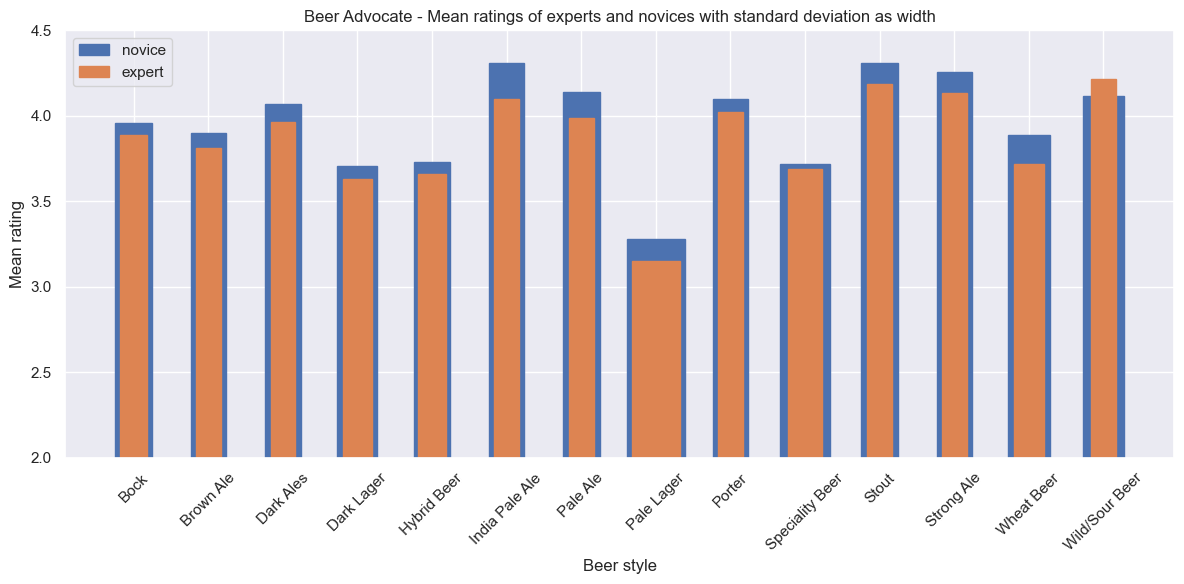

In [49]:
sns_blue = "#4C72B0"
sns_orange = "#DD8452"
colors = {0: sns_blue, 1: sns_orange}

# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_ba_mean_std_exp_nov.iterrows():
    ax.bar(
        row[0], 
        row[2], 
        width=row[3]*0.75, 
        color=colors[row[1]], 
        edgecolor=colors[row[1]],
        label=("expert" if row[1] == 1 else "novice") if ( _ in [0,1]) else ""
    )

# Customizing the plot
ax.set_xlabel("Beer style")
ax.set_ylabel("Mean rating")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="")
ax.set_title("Beer Advocate - Mean ratings of experts and novices with standard deviation as width")
plt.xticks(rotation=45)
plt.ylim([2,4.5])
plt.tight_layout()
plt.show()

In [50]:
df_rb_mean_std_exp_nov = df_rb_to_barplot.groupby(["beer_global_style","expert_or_novice"]).agg(["mean","std"]).reset_index()

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/727557566.py:8: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/727557566.py:9: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipykernel_80456/727557566.py:10: FutureWarning:

Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`

/var/folders/ng/n8p0hjyx5vg98_zrmqdwzxzw0000gn/T/ipyke

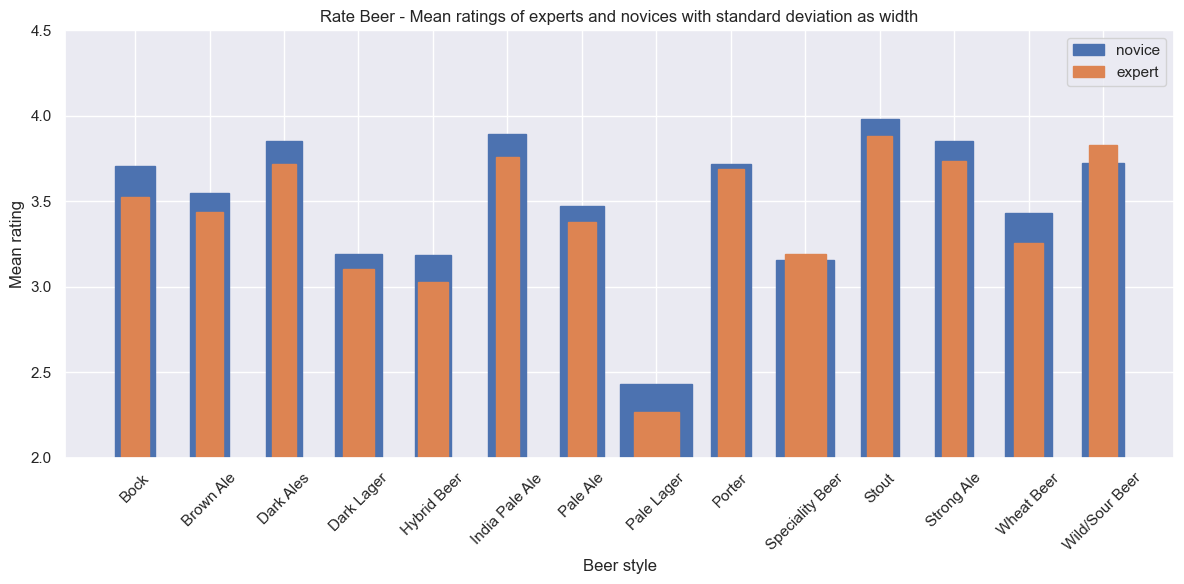

In [51]:
sns_blue = "#4C72B0"
sns_orange = "#DD8452"
colors = {0: sns_blue, 1: sns_orange}
# Plot
fig, ax = plt.subplots(figsize=(12, 6))
for _, row in df_rb_mean_std_exp_nov.iterrows():
    ax.bar(
        row[0], 
        row[2], 
        width=row[3]*0.75, 
        color=colors[row[1]], 
        edgecolor=colors[row[1]],
        label=("expert" if row[1] == 1 else "novice") if ( _ in [0,1]) else ""
    )

# Customizing the plot
ax.set_xlabel("Beer style")
ax.set_ylabel("Mean rating")
handles, labels = ax.get_legend_handles_labels()
ax.legend(handles, labels, title="")
ax.set_title("Rate Beer - Mean ratings of experts and novices with standard deviation as width")
plt.xticks(rotation=45)
plt.ylim([2,4.5])
plt.tight_layout()
plt.show()

*Interpretation*: These custom bar charts compare both the average and the standard deviation of ratings given by expert and novice users for different beer styles on Beer Advocate and Rate Beer. It show how the experts tend to give lower rating than novices as they have more persepctive on what they are tasting based on their experience. Moreover they also tend to agree more between each others than the novices showing how a higher knowledge would lead to more similar ratings.

# 5. Predictions of ratings from text reviews using NLP

We used model `nlptown/bert-base-multilingual-uncased-sentiment` to predict a score between 1 and 5 for text reviews left by users. The scores were calculated separately, but the code used is available in the `predict_rating` function in the `src/utils/nlp.py` file.

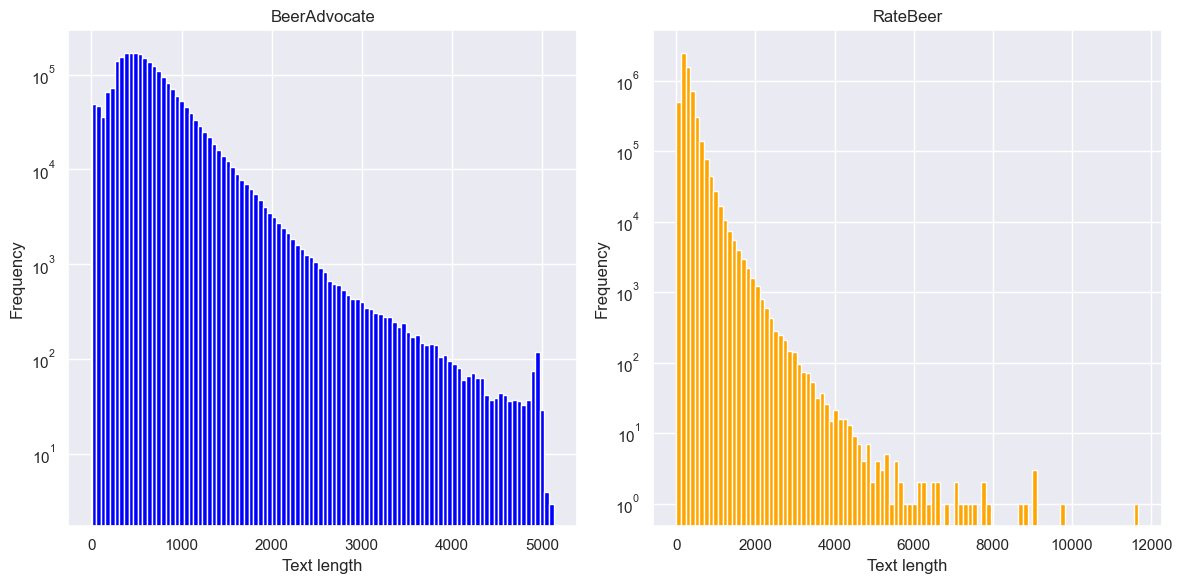

In [52]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

plt.title('Distribution of text length')

axs[0].hist(df_ba_ratings['text'].str.len(), bins=100, color='blue', alpha=1)
axs[0].set_title('BeerAdvocate')
axs[0].set_xlabel('Text length')
axs[0].set_ylabel('Frequency')
axs[0].set_yscale('log')

axs[1].hist(df_rb_ratings['text'].str.len(), bins=100, color='orange', alpha=1)
axs[1].set_title('RateBeer')
axs[1].set_xlabel('Text length')
axs[1].set_ylabel('Frequency')
axs[1].set_yscale('log')

plt.tight_layout()
plt.show()

**Interpretation :** We can observe that text length follows a power law with many short reviews and fewer and fewer as length increases.

In [53]:
df_regions = pd.read_csv("src/data/regions.csv")

`df_regions` contains the matching from country to world region to group users in broader categories. `df_ba_nlp` and `df_rb_nlp` contain the predictions computed using the `predict_rating` function.

In [54]:
df_ba_nlp = pd.read_csv("src/data/beer_advocate/nlp_predictions.csv", index_col=0)
df_rb_nlp = pd.read_csv("src/data/rate_beer/nlp_predictions.csv", index_col=0)

In [55]:
df_ba_users = df_ba_users.merge(
    df_regions, left_on="user_country_code", right_on="ISO3", how="left"
).drop(columns=["ISO3"])
df_ba_users = df_ba_users.rename(columns={"region": "user_country_region"})
df_ba_ratings = df_ba_ratings.merge(df_ba_nlp, left_index=True, right_index=True)
df_ba_ratings = df_ba_ratings.merge(df_ba_users, on="user_id")

df_rb_users = df_rb_users.merge(
    df_regions, left_on="user_country_code", right_on="ISO3", how="left"
).drop(columns=["ISO3"])
df_rb_users = df_rb_users.rename(columns={"region": "user_country_region"})
df_rb_ratings = df_rb_ratings.merge(df_rb_nlp, left_index=True, right_index=True)
df_rb_ratings = df_rb_ratings.merge(df_rb_users, on="user_id")

In [56]:
df_ba_ratings["rating_relative_error"] = (
    df_ba_ratings["rating"] - df_ba_ratings["nlp_weighted_rating"]
) / df_ba_ratings["nlp_weighted_rating"]
df_ba_ratings["rating_absolute_error"] = (
    df_ba_ratings["rating"] - df_ba_ratings["nlp_weighted_rating"]
)

df_rb_ratings["rating_relative_error"] = (
    df_rb_ratings["rating"] - df_rb_ratings["nlp_weighted_rating"]
) / df_rb_ratings["nlp_weighted_rating"]
df_rb_ratings["rating_absolute_error"] = (
    df_rb_ratings["rating"] - df_rb_ratings["nlp_weighted_rating"]
)

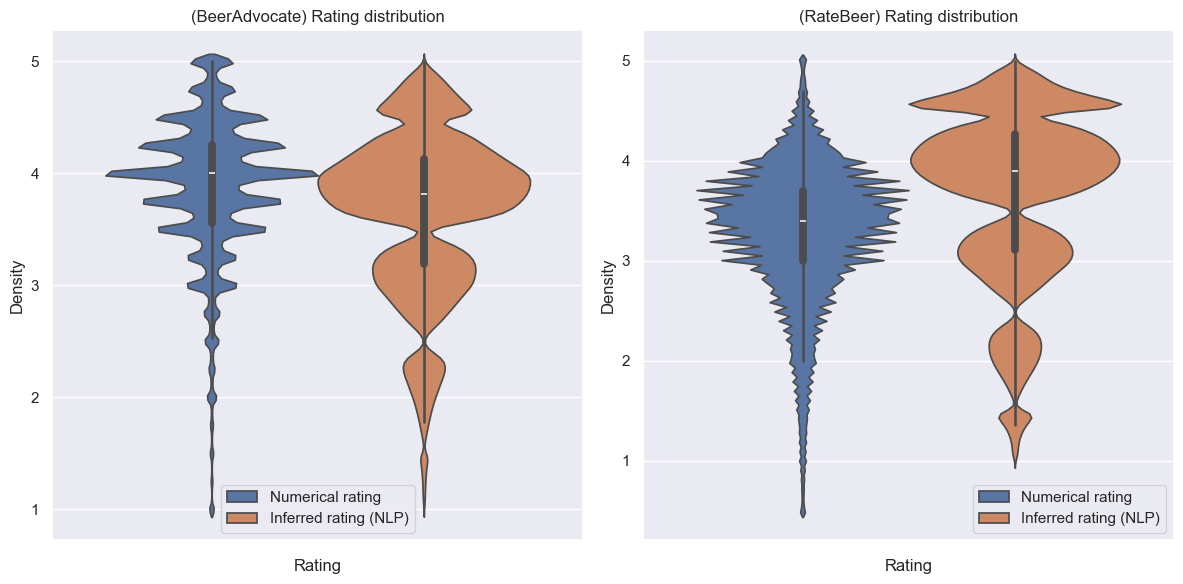

In [57]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

axs[0].set_title("(BeerAdvocate) Rating distribution")
axs[0].set_xlabel("Rating")
axs[0].set_ylabel("Density")
sns.violinplot(
    df_ba_ratings.rename(
        columns={
            "rating": "Numerical rating",
            "nlp_weighted_rating": "Inferred rating (NLP)",
        }
    ).melt(
        id_vars=["user_id", "beer_id"],
        value_vars=["Numerical rating", "Inferred rating (NLP)"],
    ),
    hue="variable",
    y="value",
    ax=axs[0],
)
axs[0].legend()

axs[1].set_title("(RateBeer) Rating distribution")
axs[1].set_xlabel("Rating")
axs[1].set_ylabel("Density")
sns.violinplot(
    df_rb_ratings.rename(
        columns={
            "rating": "Numerical rating",
            "nlp_weighted_rating": "Inferred rating (NLP)",
        }
    ).melt(
        id_vars=["user_id", "beer_id"],
        value_vars=["Numerical rating", "Inferred rating (NLP)"],
    ),
    hue="variable",
    y="value",
    ax=axs[1],
)
axs[1].legend()

plt.tight_layout()
plt.show()

**Interpretation :** The ratings predicted by the model offer a more smooth distribution because we used a weighted average of the off-by-one predictions to enhance model performance (as recommended by the documentation of the model, see the `compute_weighted_rating` in `nlp.py`). We can see that predictions are a slightly lower for Beer Advocate and a bit higher for Rate Beer on average compared to the original ones, but it's difficult to interpret these results without information on the bias brought by the model.

## User region

In [58]:
NLP_MIN_USERS_PER_REGION = 500

df_ba_nlp_regions = df_ba_ratings.dropna(subset=["user_country_region"])
df_rb_nlp_regions = df_rb_ratings.dropna(subset=["user_country_region"])

ba_users_per_region = df_ba_nlp_regions["user_country_region"].value_counts()
ba_users_per_region = ba_users_per_region[
    ba_users_per_region >= NLP_MIN_USERS_PER_REGION
]
df_ba_nlp_regions = df_ba_nlp_regions[
    df_ba_nlp_regions["user_country_region"].isin(ba_users_per_region.index)
]

rb_users_per_region = df_rb_nlp_regions["user_country_region"].value_counts()
rb_users_per_region = rb_users_per_region[
    rb_users_per_region >= NLP_MIN_USERS_PER_REGION
]
df_rb_nlp_regions = df_rb_nlp_regions[
    df_rb_nlp_regions["user_country_region"].isin(rb_users_per_region.index)
]

In [59]:
NLP_ERROR_COLUMN = "rating_absolute_error"
anova_result = f_oneway(
    *[
        group[NLP_ERROR_COLUMN].values
        for _, group in df_ba_nlp_regions.groupby("user_country_region")
    ]
)
print(f"BeerAdvocate ANOVA result: {anova_result}")

anova_result = f_oneway(
    *[
        group[NLP_ERROR_COLUMN].values
        for _, group in df_rb_nlp_regions.groupby("user_country_region")
    ]
)
print(f"RateBeer ANOVA result: {anova_result}")

BeerAdvocate ANOVA result: F_onewayResult(statistic=np.float64(287.7766799431068), pvalue=np.float64(0.0))
RateBeer ANOVA result: F_onewayResult(statistic=np.float64(2929.8287968199334), pvalue=np.float64(0.0))


**Interpretation :** With both p-values close to 0, we reject the null hypothesis that the pairwise means of all groups are equal. In other words, at least two groups have statistically different means.

In [60]:
df_ba_nlp_tuckey = tukey_test(
    df_ba_nlp_regions, "user_country_region", NLP_ERROR_COLUMN
)
df_rb_nlp_tuckey = tukey_test(
    df_ba_nlp_regions, "user_country_region", NLP_ERROR_COLUMN
)

In [61]:
G_ba = create_digraph(df_ba_nlp_tuckey, df_ba_nlp_regions, NLP_ERROR_COLUMN)
G_rb = create_digraph(df_rb_nlp_tuckey, df_rb_nlp_regions, NLP_ERROR_COLUMN)

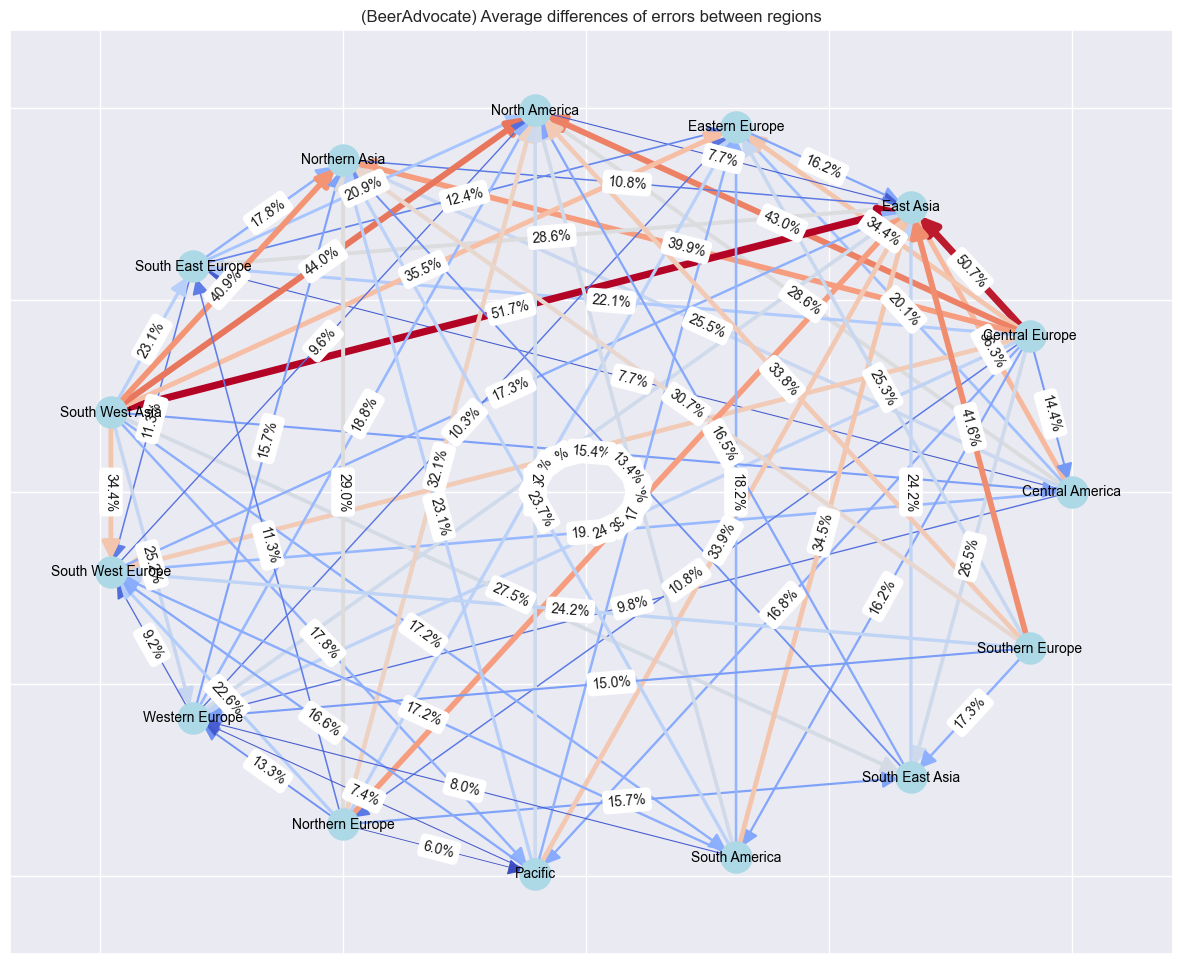

In [62]:
plt.figure(figsize=(15, 12))

plt.title("(BeerAdvocate) Average differences of errors between regions")
pos = nx.circular_layout(G_ba)

edges = G_ba.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [10 * abs(d['difference']) for (_, _, d) in edges]

nx.draw_networkx_nodes(G_ba, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_ba, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G_ba, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G_ba, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

**Interpretation :** This graph illustrates the statistically significant differences between means for each region. Each arc from left to right represents an increase in the gap from one region to another. This graph is very dense and hard to interpret, thus we only selected the most significant edges and made a cleaner one :

<img src="src/data/images/nlp_ba.png" style="width: 500px"/>

For example, the arc linking "Central Europe" to "East Asia" with a mean deviation of  means that, on average, the deviations between texts and ratings in Central Europe are  points lower than in East Asia.

Thus we can observe that the Central Europe, Northern Europe, Central America regions have smaller deviations than many other regions, and therefore the textual reviews left are closer to the final scores given. It also seems that users in East Asia tend to leave more negative comments in relation to their final ratings compared to other regions.

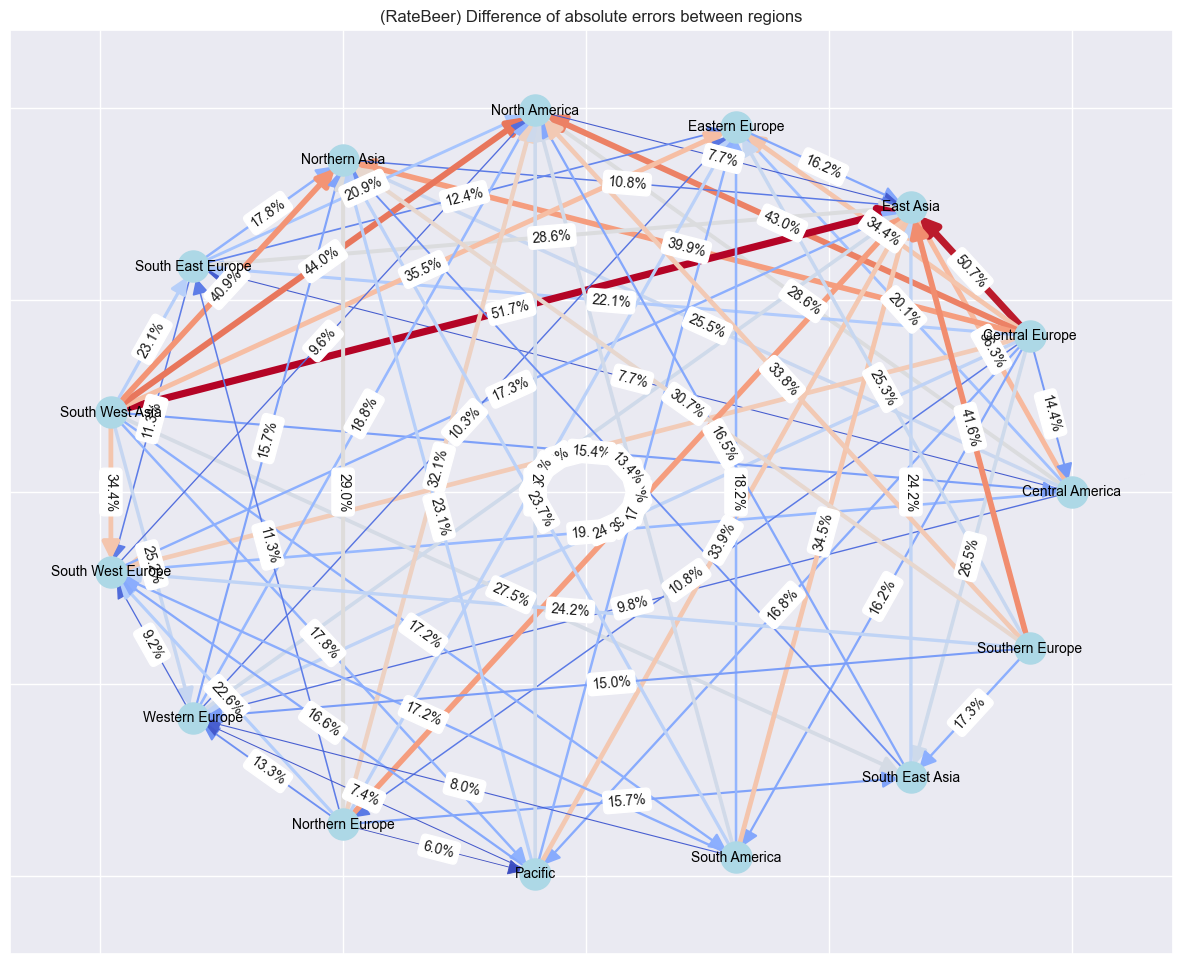

In [63]:
plt.figure(figsize=(15, 12))
plt.title('(RateBeer) Difference of absolute errors between regions')

pos = nx.circular_layout(G_rb)

edges = G_rb.edges(data=True)
edge_colors = [d['difference'] for (_, _, d) in edges]
edge_widths = [10 * abs(d['difference']) for (_, _, d) in edges]

nx.draw_networkx_nodes(G_rb, pos, node_size=500, node_color='lightblue')
nx.draw_networkx_edges(G_rb, pos, edge_color=edge_colors, width=edge_widths, edge_cmap=plt.cm.coolwarm, arrowsize=25)
nx.draw_networkx_labels(G_rb, pos, font_size=10, font_color='black', )
nx.draw_networkx_edge_labels(G_rb, pos, edge_labels={(u, v): f"{d['difference']*100:.1f}%" for (u, v, d) in edges})

plt.show()

**Interpretation :** Similarly we made a cleaner one :

<img src="src/data/images/nlp_rb.png" style="width: 500px"/>

The trends are similar between Beer Advocate and Rate Beers with Central Europe, Northern Europe and Central America showing lower spreads than East Asia, North America and Northern Asia. In particular, there is on average  points more difference between the texts and scores of users in East Asia than those in Central Europe.

In [64]:
print(
    f"BeerAdvocate : nx.is_directed_acyclic_graph(G_ba)={nx.is_directed_acyclic_graph(G_ba)}"
)
print(
    f"RateBeer :  nx.is_directed_acyclic_graph(G_rb)={nx.is_directed_acyclic_graph(G_rb)}"
)

BeerAdvocate : nx.is_directed_acyclic_graph(G_ba)=True
RateBeer :  nx.is_directed_acyclic_graph(G_rb)=True


Both graphs are DAGs which mean there is no cycle between regions.

# 6. Preferences and ratings

This section looks at how different groups of users, segmented according to the style they have consumed most, rate other styles.

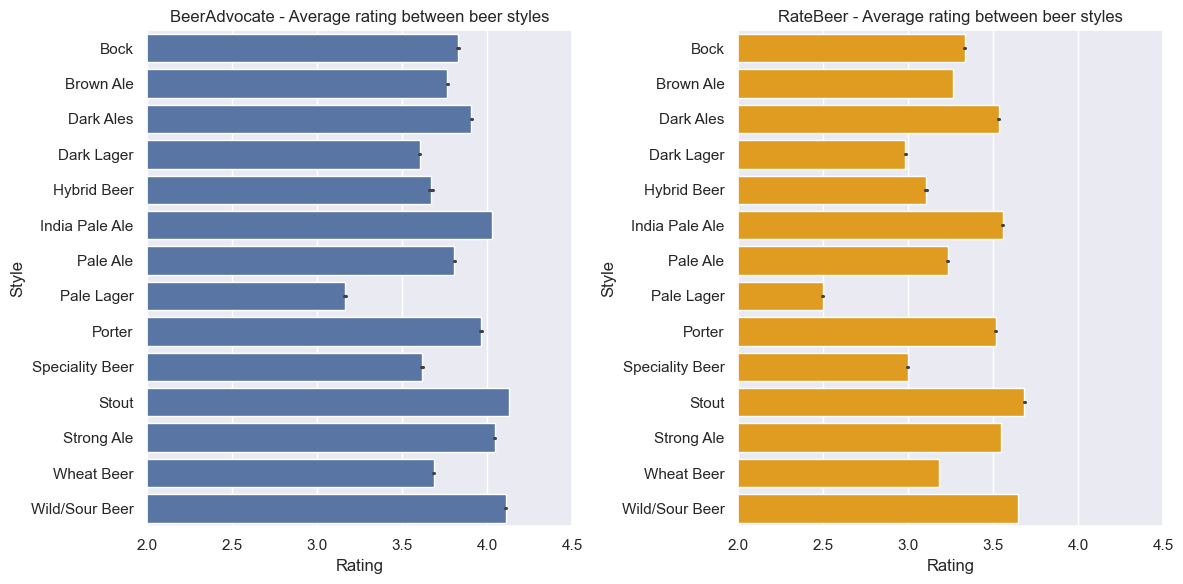

In [65]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

styles_order = np.sort(df_ba_ratings["beer_global_style"].unique())

axs[0].set_title('BeerAdvocate - Average rating between beer styles')
axs[0].set_xlabel('Rating')
axs[0].set_ylabel('Style')
axs[0].set_xlim([2, 4.5])
sns.barplot(df_ba_ratings, y='beer_global_style', x='rating', ax=axs[0], order=styles_order)

axs[1].set_title('RateBeer - Average rating between beer styles')
axs[1].set_xlabel('Rating')
axs[1].set_ylabel('Style')
axs[1].set_xlim([2, 4.5])
sns.barplot(df_rb_ratings, y='beer_global_style', x='rating', color='orange', ax=axs[1], order=styles_order)

plt.tight_layout()
plt.show()

**Interpretation :** We can see that Pale Lager is the lowest-rated beer style on both sites, while Stouts and Wild/Sour are rated fairly highly on both sites.

We define the dominant style as the style most highly rated by a user.

In [66]:
df_ba_ratings["dominant_style"] = df_ba_ratings.groupby("user_id")[
    "beer_global_style"
].transform(lambda x: x.mode()[0])
df_rb_ratings["dominant_style"] = df_rb_ratings.groupby("user_id")[
    "beer_global_style"
].transform(lambda x: x.mode()[0])

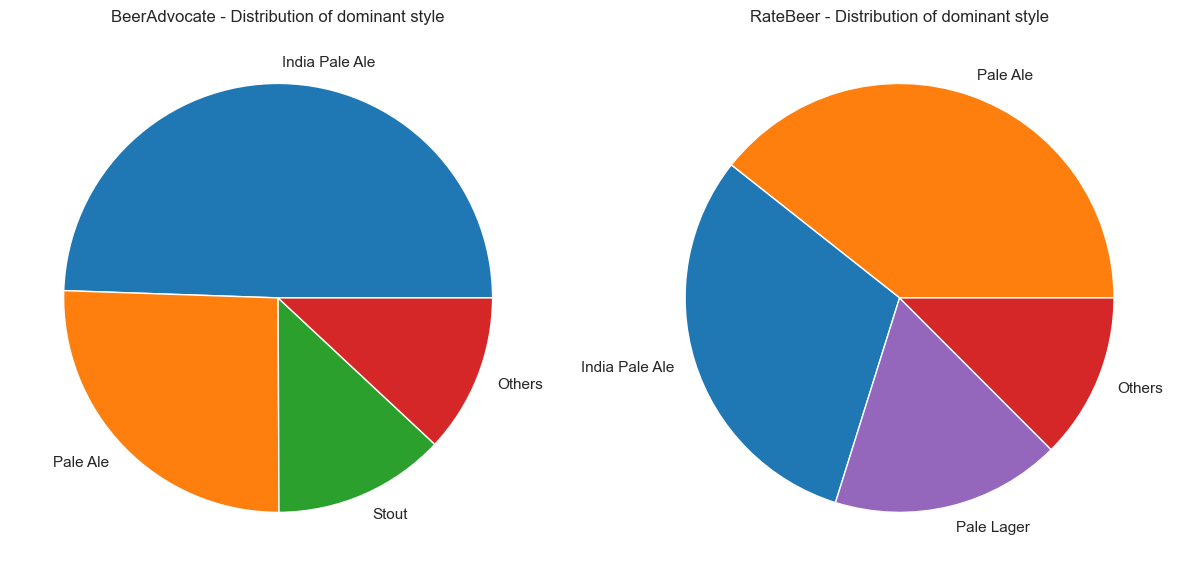

In [67]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs = axs.ravel()

palette = sns.color_palette('tab10', n_colors=5)

axs[0].set_title('BeerAdvocate - Distribution of dominant style')
axs[0].set_xlim([2, 4.5])
df_ba_dominants_count = df_ba_ratings["dominant_style"].value_counts()
pd.concat([
    df_ba_dominants_count.nlargest(3), 
    pd.Series({'Others': df_ba_dominants_count.drop(df_ba_dominants_count.nlargest(3).index).sum()})
]).plot.pie(ax=axs[0], colors=[palette[0], palette[1], palette[2], palette[3]])

axs[1].set_title('RateBeer - Distribution of dominant style')
axs[1].set_xlim([2, 4.5])
df_rb_dominants_count = df_rb_ratings["dominant_style"].value_counts()
pd.concat([
    df_rb_dominants_count.nlargest(3), 
    pd.Series({'Others': df_rb_dominants_count.drop(df_rb_dominants_count.nlargest(3).index).sum()})
]).plot.pie(ax=axs[1], colors=[palette[1], palette[0], palette[4], palette[3]])

plt.tight_layout()
plt.show()

**Interpretation :** We can observe that on both websites, IPA and Pale Ale are fairly popular and represent the majority of users in dominant groups.


In [68]:
df_ba_relationships = analyze_relationships(df_ba_ratings)
df_rb_relationships = analyze_relationships(df_rb_ratings)

In [69]:
df_ba_relationships.head()

group_style    target_style  mean_rating  std_rating  num_ratings
0  India Pale Ale  India Pale Ale     0.119238    0.512801       309309
1  India Pale Ale       Dark Ales    -0.028160    0.490907        38554
2  India Pale Ale           Stout     0.204624    0.493815       123787
3  India Pale Ale      Strong Ale     0.120665    0.505247        67829
4  India Pale Ale        Pale Ale    -0.098555    0.516909       149985

In [70]:
df_rb_relationships.head()

group_style target_style  mean_rating  std_rating  num_ratings
0   Dark Ales    Dark Ales     0.246669    0.624579        25387
1   Dark Ales     Pale Ale    -0.117190    0.607283         9723
2   Dark Ales   Pale Lager    -0.929461    0.781798         8571
3   Dark Ales   Wheat Beer    -0.167601    0.600618         5670
4   Dark Ales       Porter     0.199496    0.587425         3688

In [71]:
G_ba_preferences = create_preference_digraph(df_ba_relationships)
G_rb_preferences = create_preference_digraph(df_rb_relationships)

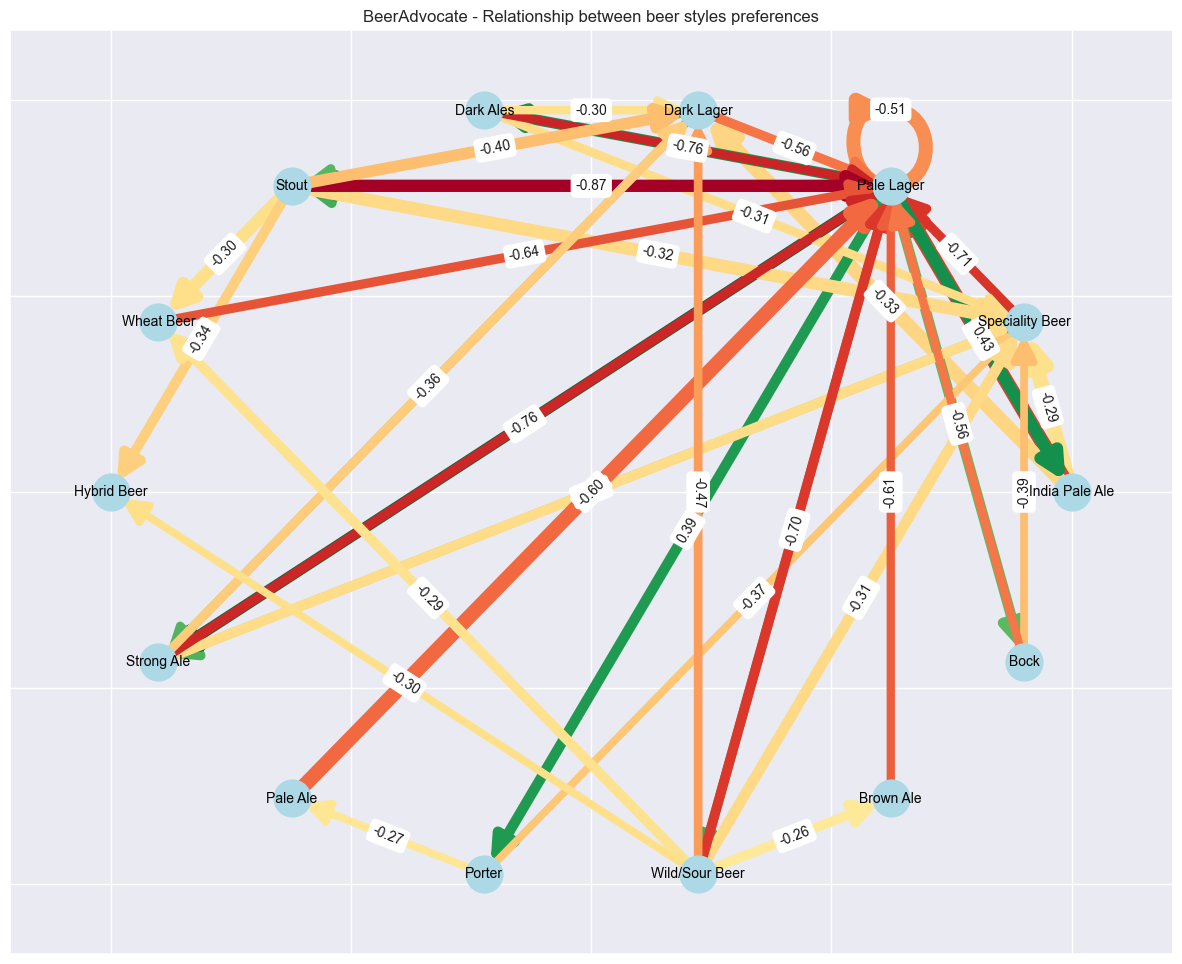

In [72]:
plt.figure(figsize=(15, 12))
plt.title('BeerAdvocate - Relationship between beer styles preferences')
pos = nx.circular_layout(G_ba_preferences)

nx.draw_networkx_nodes(G_ba_preferences, pos, node_size=700, node_color="lightblue")

edges = G_ba_preferences.edges(data=True)
edge_colors = [d["rating"] for (_, _, d) in edges]
edge_widths = [np.log(d["weight"]) for (_, _, d) in edges]

nx.draw_networkx_edges(
    G_ba_preferences,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.RdYlGn,
    arrowsize=35,
)
nx.draw_networkx_labels(G_ba_preferences, pos, font_size=10, font_color="black")
nx.draw_networkx_edge_labels(
    G_ba_preferences,
    pos,
    edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges},
)

plt.show()

**Interpretation :** This graph compares how each dominant group in a style rates the other styles against their average rating across all styles. For the example the edge with value $-0.59$ from "Pale Ale" to "Pale Lager" means that users that are Pale Ale-dominant tend to rate Pale Lager $0.59$ points lower than their average on all styles. We can thus observe that Pale Lager are not very liked, even by the Pale Lager-dominant group themselves.

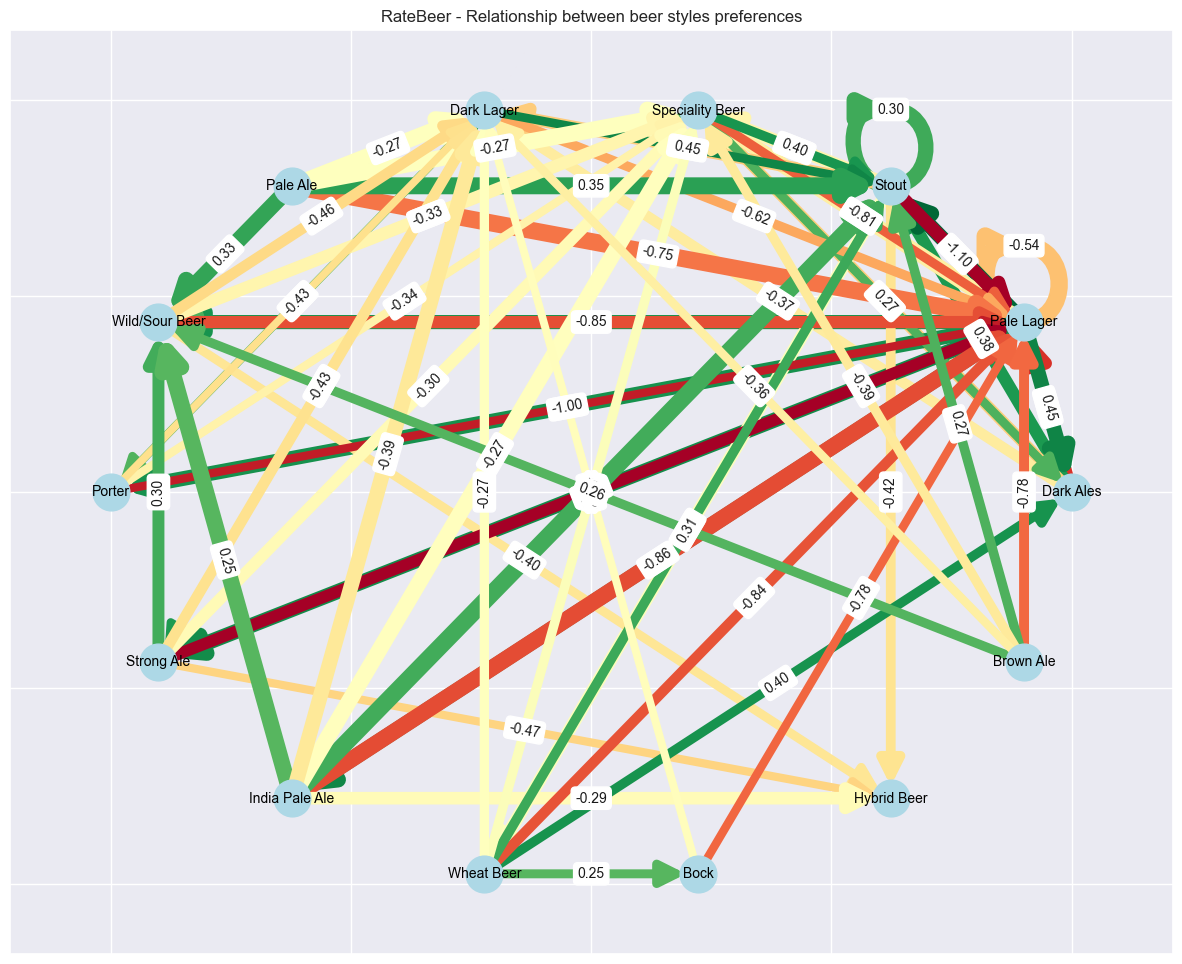

In [73]:
plt.figure(figsize=(15, 12))
plt.title('RateBeer - Relationship between beer styles preferences')
pos = nx.circular_layout(G_rb_preferences)

nx.draw_networkx_nodes(G_rb_preferences, pos, node_size=700, node_color="lightblue")

edges = G_rb_preferences.edges(data=True)
edge_colors = [d["rating"] for (_, _, d) in edges]
edge_widths = [np.log(d["weight"]) for (_, _, d) in edges]

nx.draw_networkx_edges(
    G_rb_preferences,
    pos,
    edge_color=edge_colors,
    width=edge_widths,
    edge_cmap=plt.cm.RdYlGn,
    arrowsize=35,
)
nx.draw_networkx_labels(G_rb_preferences, pos, font_size=10, font_color="black")
nx.draw_networkx_edge_labels(
    G_rb_preferences,
    pos,
    edge_labels={(u, v): f"{d['rating']:.2f}" for (u, v, d) in edges},
)

plt.show()

**Interpretation :** This graph compares how each dominant group in a style rates the other styles against their average rating across all styles. For the example the edge with value $-0.75$ from "Pale Ale" to "Pale Lager" means that users that are Pale Ale-dominant tend to rate Pale Lager $0.75$ points lower than their average on all styles. We can thus observe that Pale Lager are not very liked, even by the Pale Lager-dominant group themselves.